# Análisis Exploratorio y Preparación de Datos

Este notebook documenta el proceso completo de limpieza, transformación y preparación del dataset para modelado predictivo de precios de propiedades tipo Airbnb. Se siguen los siguientes pasos:

1. Revisión de variable objetivo (`Price`) y transformación a logaritmo (`Price_log`)
2. Imputación y limpieza de valores faltantes
3. Codificación de variables categóricas
4. Revisión de colinealidad mediante VIF y ajustes
5. Escalado de variables numéricas
6. Exportación del dataset limpio y listo para modelado

--------------------------------------------

LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
import re 

In [5]:
from sklearn.preprocessing import RobustScaler

In [6]:
from sklearn.cluster import KMeans

In [7]:
from sklearn.decomposition import PCA

In [8]:
import joblib

--------------

In [9]:
# Defino la URL del dataset y lo cargo
url = "https://raw.githubusercontent.com/gonzalezulises/airbnb-pricing-ml/refs/heads/main/data/raw/airbnb-listings-extract.csv"

# Creo un único DataFrame principal
df_raw = pd.read_csv(url, sep=';', engine='python', on_bad_lines='skip')

-----------------

In [10]:
# ======= EXPLORACIÓN INICIAL =======
print(f"Dimensiones del dataset: {df_raw.shape}")
print(f"\nPrimeras 5 filas del dataset:")
df_raw.head()

Dimensiones del dataset: (14780, 89)

Primeras 5 filas del dataset:


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,10.0,8.0,10.0,HUTB-006721,NaN,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,17584891,https://www.airbnb.com/rooms/17584891,20170407214050,2017-04-08,"Style Terrace Red, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,NaN,NaN,NaN,HUTB-007527,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,5398030,https://www.airbnb.com/rooms/5398030,20170407214050,2017-04-08,Picasso Suite 1.4 Paseo de Gracia,Live like a local in Barcelona's most chic dis...,You wake up to the sun rising over Barcelona's...,Live like a local in Barcelona's most chic dis...,none,We're right in the heart of the chic L'Eixampl...,...,10.0,10.0,9.0,NaN,NaN,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,18104606,https://www.airbnb.com/rooms/18104606,20170407214050,2017-04-08,Smart City Centre Apartment II,"Unique apartment in vibrant neighborhoods, car...","License: HUTB-005313 Charming apartment, locat...","Unique apartment in vibrant neighborhoods, car...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


In [11]:
# Muestro información básica sobre el DataFrame
print("\nResumen de tipos de datos:")
df_info = pd.DataFrame({
    'tipo': df_raw.dtypes,
    'no_nulos': df_raw.count(),
    'nulos': df_raw.isnull().sum(),
    'nulos_%': (df_raw.isnull().sum() / len(df_raw) * 100).round(2),
    'valores_unicos': df_raw.nunique()
})
display(df_info.sort_values('nulos_%', ascending=False).head(10))


Resumen de tipos de datos:


,tipo,no_nulos,nulos,nulos_%,valores_unicos
Has Availability,object,12,14768,99.92,1
Host Acceptance Rate,object,39,14741,99.74,12
Jurisdiction Names,object,227,14553,98.46,12
License,object,349,14431,97.64,316
Square Feet,float64,598,14182,95.95,103
Monthly Price,float64,3561,11219,75.91,586
Weekly Price,float64,3590,11190,75.71,388
Notes,object,5644,9136,61.81,4652
Security Deposit,float64,6256,8524,57.67,124
Interaction,object,8228,6552,44.33,6585


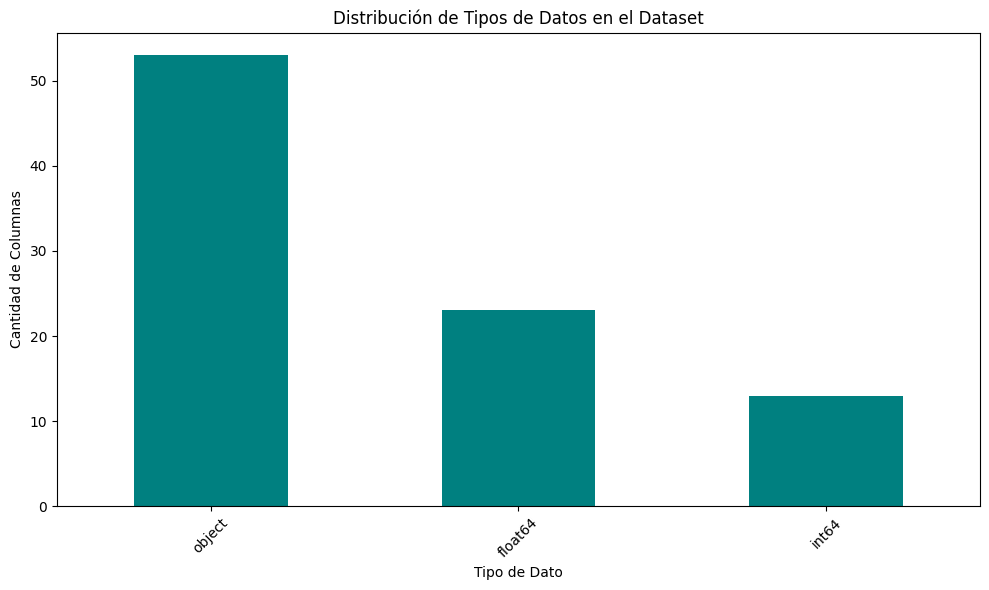

In [12]:
# Visualización: Distribución de tipos de datos en el dataset
plt.figure(figsize=(10, 6))
df_raw.dtypes.value_counts().plot(kind='bar', color='teal')
plt.title('Distribución de Tipos de Datos en el Dataset')
plt.xlabel('Tipo de Dato')
plt.ylabel('Cantidad de Columnas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

------------------

ANÁLISIS DE TIPOS DE DATOS Y VALORES FALTANTES

In [13]:
# Verifico los tipos de datos
print(df_raw.dtypes.value_counts())

object     53
float64    23
int64      13
dtype: int64


In [14]:
# Analizo valores faltantes
missing_values = df_raw.isnull().sum()
missing_percent = (missing_values / len(df_raw)) * 100
# Creo un DataFrame temporal para visualización, sin almacenarlo en variable
print("Columnas con más de 50% de valores faltantes:")
missing_df = pd.DataFrame({
    'missing_count': missing_values,
    'missing_percent': missing_percent
}).sort_values('missing_percent', ascending=False)
print(missing_df[missing_df['missing_percent'] > 50].head(10))

Columnas con más de 50% de valores faltantes:
                      missing_count  missing_percent
Has Availability              14768        99.918809
Host Acceptance Rate          14741        99.736130
Jurisdiction Names            14553        98.464141
License                       14431        97.638701
Square Feet                   14182        95.953992
Monthly Price                 11219        75.906631
Weekly Price                  11190        75.710419
Notes                          9136        61.813261
Security Deposit               8524        57.672530


/var/folders/xz/cy4m1yx914dd0zx5s4lc56k00000gn/T/ipykernel_64876/202983730.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_df['missing_percent'][:20], y=missing_df.index[:20], palette='YlOrRd_r')


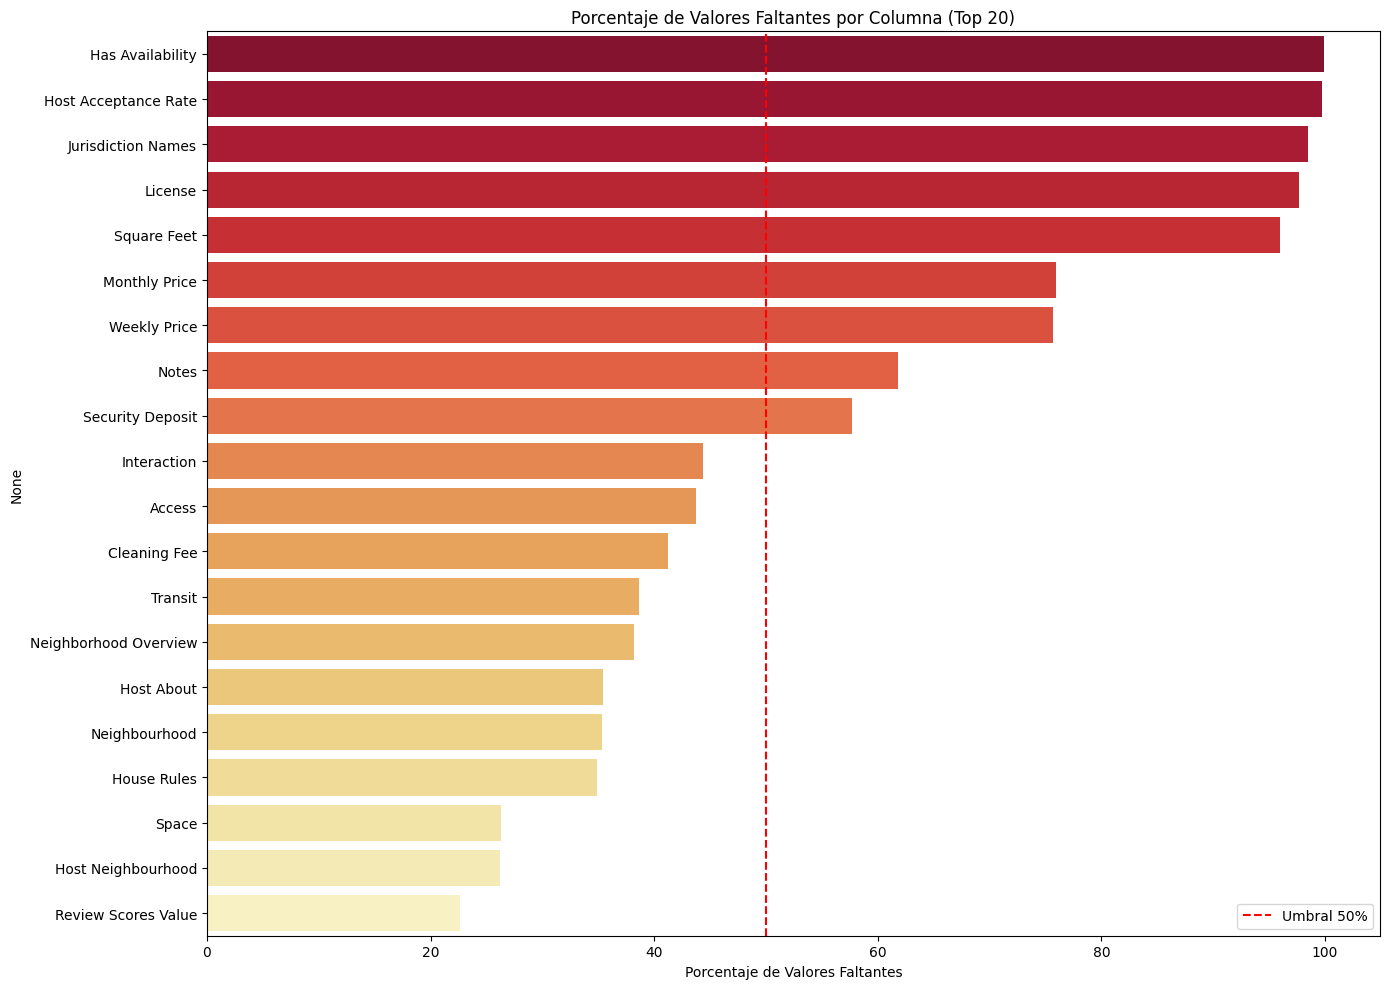

In [15]:
# Visualización: Valores faltantes por columna (top 20)
plt.figure(figsize=(14, 10))
sns.barplot(x=missing_df['missing_percent'][:20], y=missing_df.index[:20], palette='YlOrRd_r')
plt.title('Porcentaje de Valores Faltantes por Columna (Top 20)')
plt.xlabel('Porcentaje de Valores Faltantes')
plt.axvline(x=50, color='red', linestyle='--', label='Umbral 50%')
plt.legend()
plt.tight_layout()
plt.show()

ANÁLISIS INICIAL DE LA VARIABLE OBJETIVO (PRECIO)

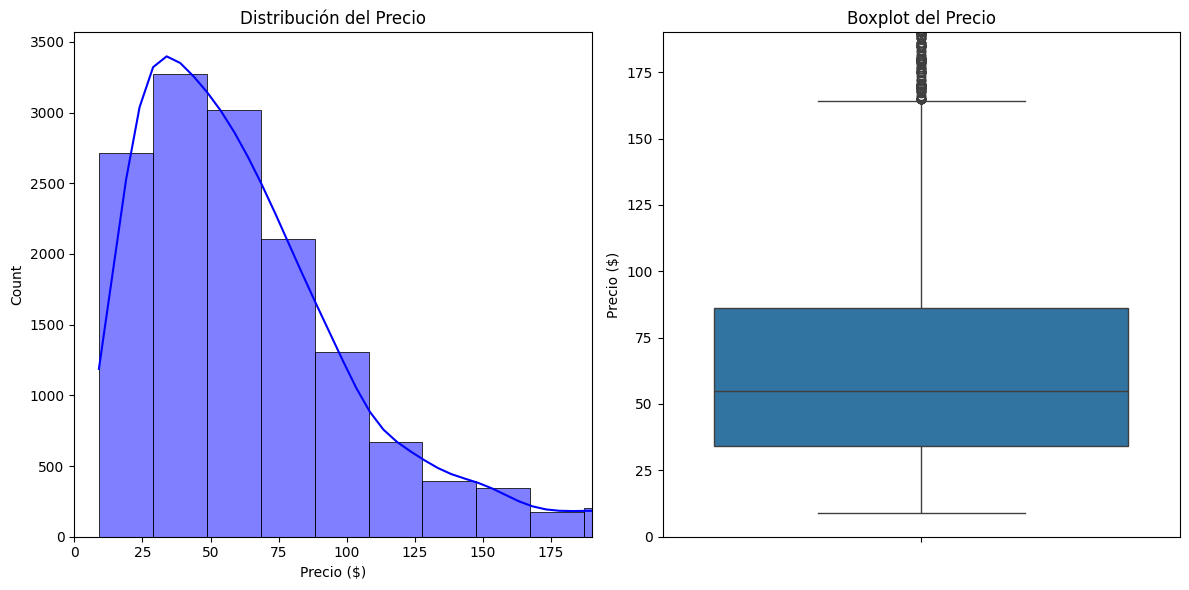

Estadísticas del precio: 
count    14763.000000
mean        73.561471
std         72.062050
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64
Asimetría (skewness): 4.36
Kurtosis: 29.79


In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_raw['Price'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribución del Precio')
plt.xlabel('Precio ($)')
plt.xlim(0, df_raw['Price'].quantile(0.95))  # Limito el eje x al percentil 95 para mejor visualización

plt.subplot(1, 2, 2)
sns.boxplot(y=df_raw['Price'].dropna())
plt.title('Boxplot del Precio')
plt.ylabel('Precio ($)')
plt.ylim(0, df_raw['Price'].quantile(0.95))

plt.tight_layout()
plt.show()

print(f"Estadísticas del precio: \n{df_raw['Price'].describe()}")
print(f"Asimetría (skewness): {df_raw['Price'].skew():.2f}")
print(f"Kurtosis: {df_raw['Price'].kurtosis():.2f}")


RELACIONES PRINCIPALES CON EL PRECIO

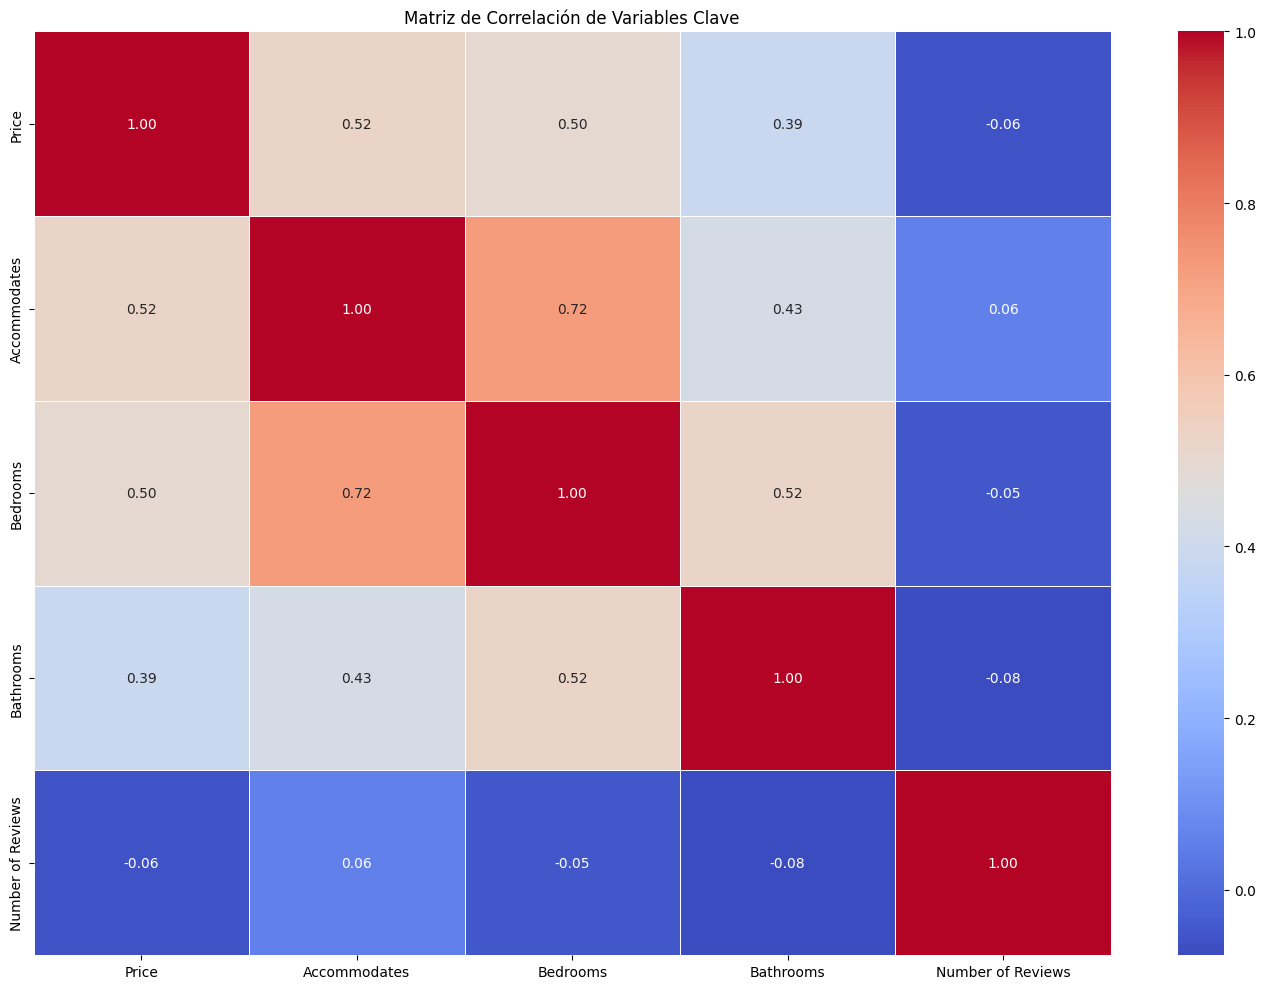

In [17]:
# Análisis de relaciones principales con el precio
key_features = ['Price', 'Accommodates', 'Bedrooms', 'Bathrooms', 'Number of Reviews']
key_df = df_raw[key_features].dropna()

plt.figure(figsize=(14, 10))
sns.heatmap(key_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Clave')
plt.tight_layout()
plt.show()

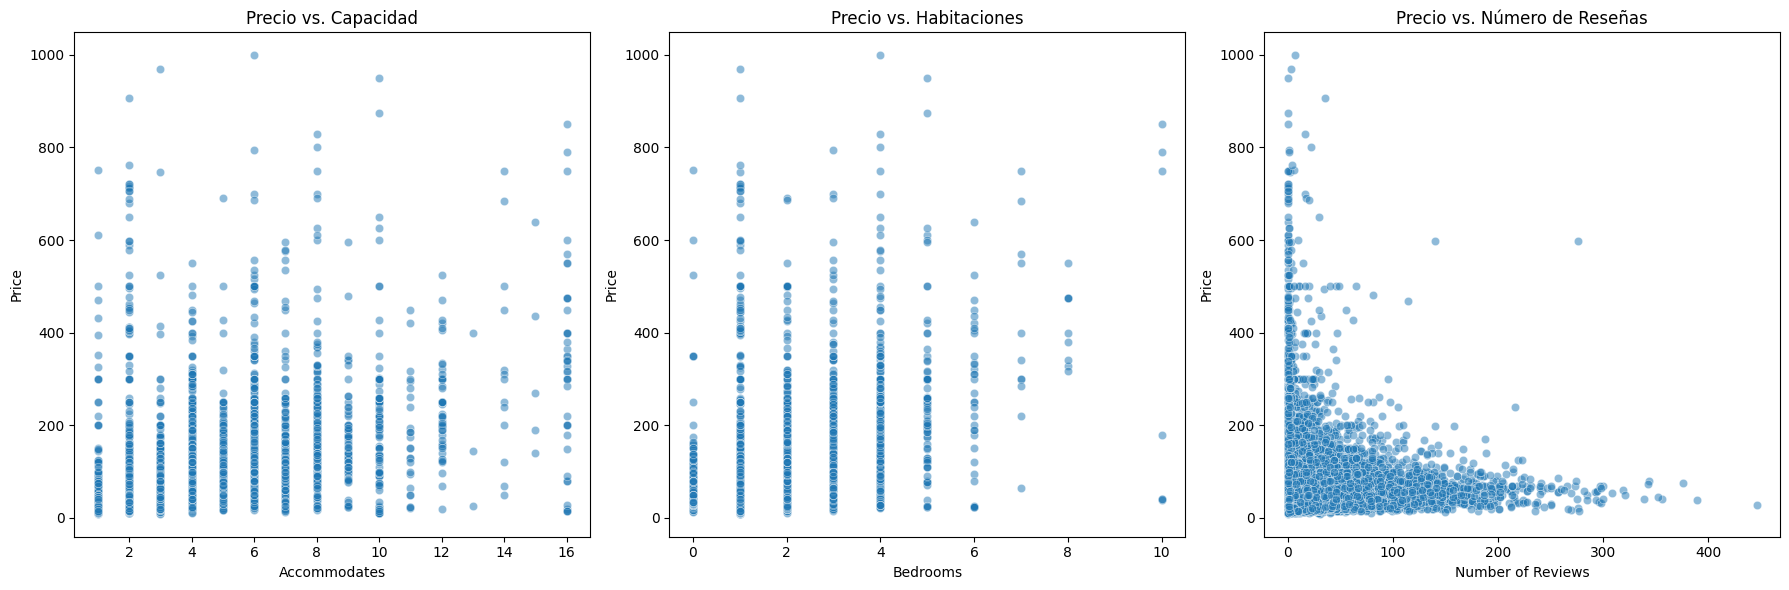

In [18]:
# Muestro algunas relaciones importantes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x='Accommodates', y='Price', data=key_df, alpha=0.5, ax=axes[0])
axes[0].set_title('Precio vs. Capacidad')

sns.scatterplot(x='Bedrooms', y='Price', data=key_df, alpha=0.5, ax=axes[1])
axes[1].set_title('Precio vs. Habitaciones')

sns.scatterplot(x='Number of Reviews', y='Price', data=key_df, alpha=0.5, ax=axes[2])
axes[2].set_title('Precio vs. Número de Reseñas')

plt.tight_layout()
plt.show()


INICIANDO PROCESO DE LIMPIEZA

In [19]:
# Creo un único DataFrame de trabajo, conservando el original
df_clean = df_raw.copy()

# Identifico columnas a eliminar por alto % de valores faltantes (>50%)
high_missing_cols = missing_df[missing_df['missing_percent'] > 50].index.tolist()
print(f"Identificadas {len(high_missing_cols)} columnas con >50% valores faltantes")

# Elimino identificadores y URLs que no son útiles para la predicción
id_url_cols = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 
    'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL', 
    'Host Thumbnail Url', 'Host Picture Url', 'Calendar last Scraped'
]
print(f"Identificadas {len(id_url_cols)} columnas de identificadores/URLs para eliminar")

# Elimino columnas con texto libre extenso que requeriría NLP
text_cols = [
    'Description', 'Neighborhood Overview', 'Notes', 'Transit', 
    'Access', 'Interaction', 'House Rules', 'Host About', 'Experiences Offered',
    'Space', 'Summary'
]
print(f"Identificadas {len(text_cols)} columnas de texto libre extenso para eliminar")

Identificadas 9 columnas con >50% valores faltantes
Identificadas 12 columnas de identificadores/URLs para eliminar
Identificadas 11 columnas de texto libre extenso para eliminar


In [20]:
# Combino todas las columnas a eliminar
cols_to_drop = high_missing_cols + id_url_cols + text_cols

# Elimino duplicados
duplicates = df_clean.duplicated().sum()
print(f"\nVerificando duplicados: {duplicates} filas duplicadas")

# Elimino las columnas en un solo paso
df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])
print(f"DataFrame después de limpieza inicial: {df_clean.shape[0]:,} filas × {df_clean.shape[1]:,} columnas")

# Muestro cómo quedó el DataFrame después de la limpieza inicial
print("\nMuestra del DataFrame después de la limpieza inicial:")
display(df_clean.head())


Verificando duplicados: 0 filas duplicadas
DataFrame después de limpieza inicial: 14,780 filas × 58 columnas

Muestra del DataFrame después de la limpieza inicial:


,Name,Host ID,Host Name,Host Since,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,...,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,The Loft-Full Bath-Deck w/View,58386783,John,2016-02-11,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,NaN,1.0,1.0,...,10.0,10.0,10.0,10.0,10.0,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,"Claris I, Friendly Rentals",102947901,Claudia,2016-11-08,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,...,10.0,10.0,10.0,8.0,10.0,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,"Style Terrace Red, Friendly Rentals",102947901,Claudia,2016-11-08,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,...,NaN,NaN,NaN,NaN,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,Picasso Suite 1.4 Paseo de Gracia,131794,Damien,2010-05-25,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,27.0,...,9.0,10.0,10.0,10.0,9.0,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,Smart City Centre Apartment II,54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,207.0,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


/var/folders/xz/cy4m1yx914dd0zx5s4lc56k00000gn/T/ipykernel_64876/988637285.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Etapa', y='Columnas', data=df_shapes, palette=['darkblue', 'mediumseagreen'])


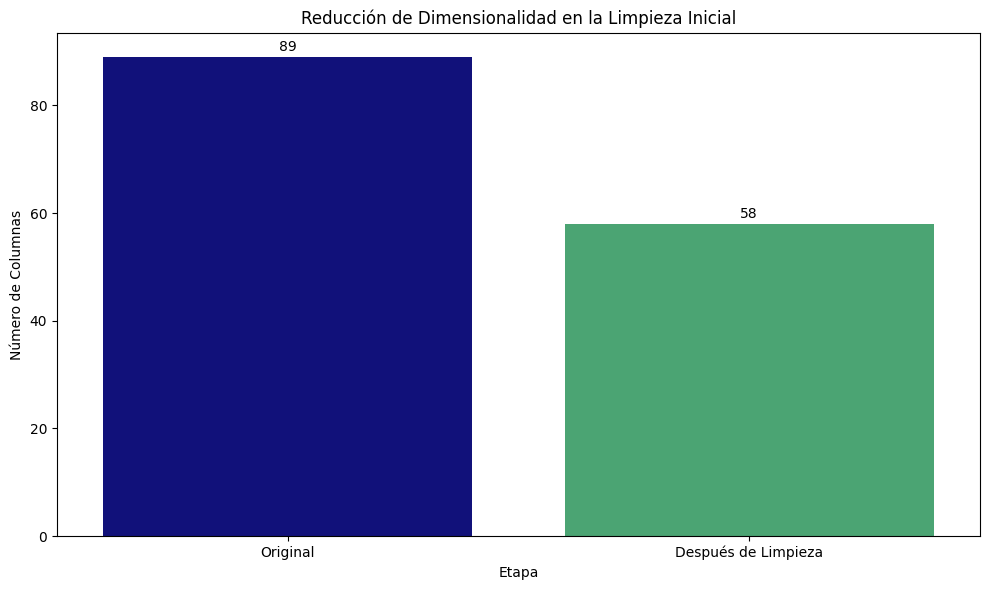

In [21]:
# Visualización: Comparación de la cantidad de columnas antes/después
plt.figure(figsize=(10, 6))
df_shapes = pd.DataFrame({
    'Etapa': ['Original', 'Después de Limpieza'],
    'Columnas': [df_raw.shape[1], df_clean.shape[1]]
})
sns.barplot(x='Etapa', y='Columnas', data=df_shapes, palette=['darkblue', 'mediumseagreen'])
plt.title('Reducción de Dimensionalidad en la Limpieza Inicial')
plt.ylabel('Número de Columnas')
for i, v in enumerate(df_shapes['Columnas']):
    plt.text(i, v + 1, str(v), ha='center')
plt.tight_layout()
plt.show()

In [22]:
# Verifico los tipos de datos después de la limpieza inicial
print("\nDistribución de tipos de datos después de la limpieza inicial:")
type_counts = df_clean.dtypes.value_counts()
print(type_counts)


Distribución de tipos de datos después de la limpieza inicial:
object     28
float64    19
int64      11
dtype: int64


In [23]:
# Análisis de valores faltantes restantes
missing_after = df_clean.isnull().sum()
missing_pct_after = (missing_after / len(df_clean) * 100).round(2)
missing_df_after = pd.DataFrame({
    'conteo': missing_after,
    'porcentaje': missing_pct_after
}).sort_values('porcentaje', ascending=False)

print("\nValores faltantes después de la limpieza inicial (top 10):")
display(missing_df_after[missing_df_after['conteo'] > 0].head(10))


Valores faltantes después de la limpieza inicial (top 10):


,conteo,porcentaje
Cleaning Fee,6093,41.22
Neighbourhood,5229,35.38
Host Neighbourhood,3876,26.22
Review Scores Location,3340,22.60
Review Scores Value,3341,22.60
Review Scores Checkin,3337,22.58
Review Scores Accuracy,3326,22.50
Review Scores Cleanliness,3320,22.46
Review Scores Communication,3320,22.46
Review Scores Rating,3304,22.35


TRANSFORMACIÓN DE FECHAS

In [24]:
# Convierto columnas de fecha a datetime
date_cols = ['Host Since', 'First Review', 'Last Review']
for col in date_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

In [25]:
# Verifico la conversión
print("Muestra de las columnas de fecha convertidas:")
display(df_clean[date_cols].head())

# Calculo la fecha de referencia (la más reciente del dataset)
fecha_referencia = df_clean[date_cols].max().max()
print(f"Fecha de referencia para cálculos: {fecha_referencia}")

# Creo variables de antigüedad en un solo paso
df_clean['host_age_years'] = (fecha_referencia - df_clean['Host Since']).dt.days / 365.25
df_clean['days_since_first_review'] = (fecha_referencia - df_clean['First Review']).dt.days
df_clean['days_since_last_review'] = (fecha_referencia - df_clean['Last Review']).dt.days
df_clean['review_gap_years'] = (df_clean['days_since_first_review'] - df_clean['days_since_last_review']) / 365.25

print("\nMuestra de las nuevas variables temporales creadas:")
display(df_clean[['host_age_years', 'days_since_first_review', 
                  'days_since_last_review', 'review_gap_years']].head())

Muestra de las columnas de fecha convertidas:


,Host Since,First Review,Last Review
0,2016-02-11,2016-03-13,2017-02-26
1,2016-11-08,2017-03-05,2017-03-05
2,2016-11-08,NaT,NaT
3,2010-05-25,2016-04-17,2017-03-02
4,2016-01-12,NaT,NaT


Fecha de referencia para cálculos: 2017-06-13 00:00:00

Muestra de las nuevas variables temporales creadas:


,host_age_years,days_since_first_review,days_since_last_review,review_gap_years
0,1.336071,457.0,107.0,0.958248
1,0.594114,100.0,100.0,0.000000
2,0.594114,NaN,NaN,NaN
3,7.052704,422.0,103.0,0.873374
4,1.418207,NaN,NaN,NaN


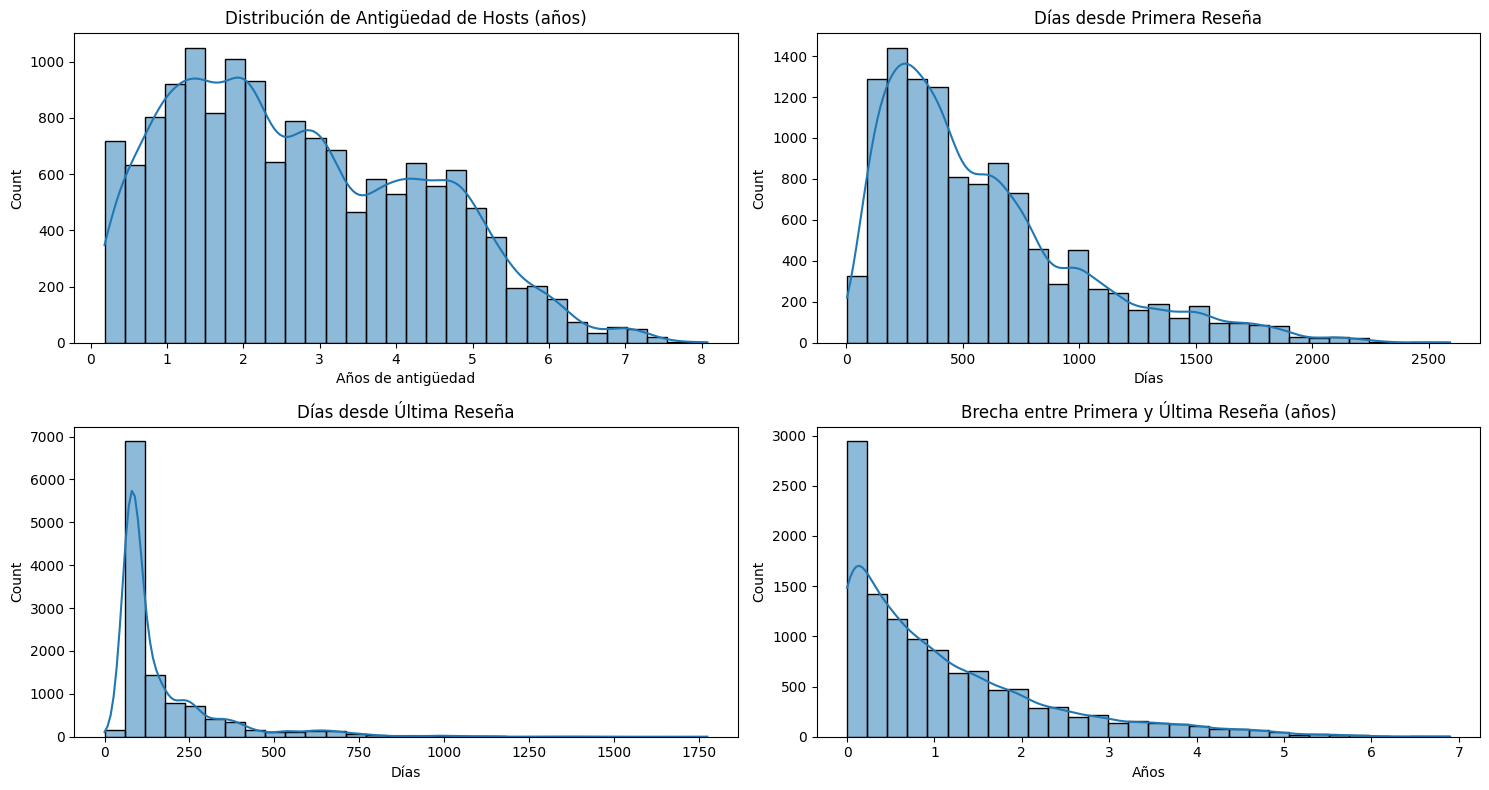

In [26]:
# Visualización: Distribución de la antigüedad de los hosts
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.histplot(df_clean['host_age_years'].dropna(), bins=30, kde=True)
plt.title('Distribución de Antigüedad de Hosts (años)')
plt.xlabel('Años de antigüedad')

plt.subplot(2, 2, 2)
sns.histplot(df_clean['days_since_first_review'].dropna(), bins=30, kde=True)
plt.title('Días desde Primera Reseña')
plt.xlabel('Días')

plt.subplot(2, 2, 3)
sns.histplot(df_clean['days_since_last_review'].dropna(), bins=30, kde=True)
plt.title('Días desde Última Reseña')
plt.xlabel('Días')

plt.subplot(2, 2, 4)
sns.histplot(df_clean['review_gap_years'].dropna(), bins=30, kde=True)
plt.title('Brecha entre Primera y Última Reseña (años)')
plt.xlabel('Años')

plt.tight_layout()
plt.show()

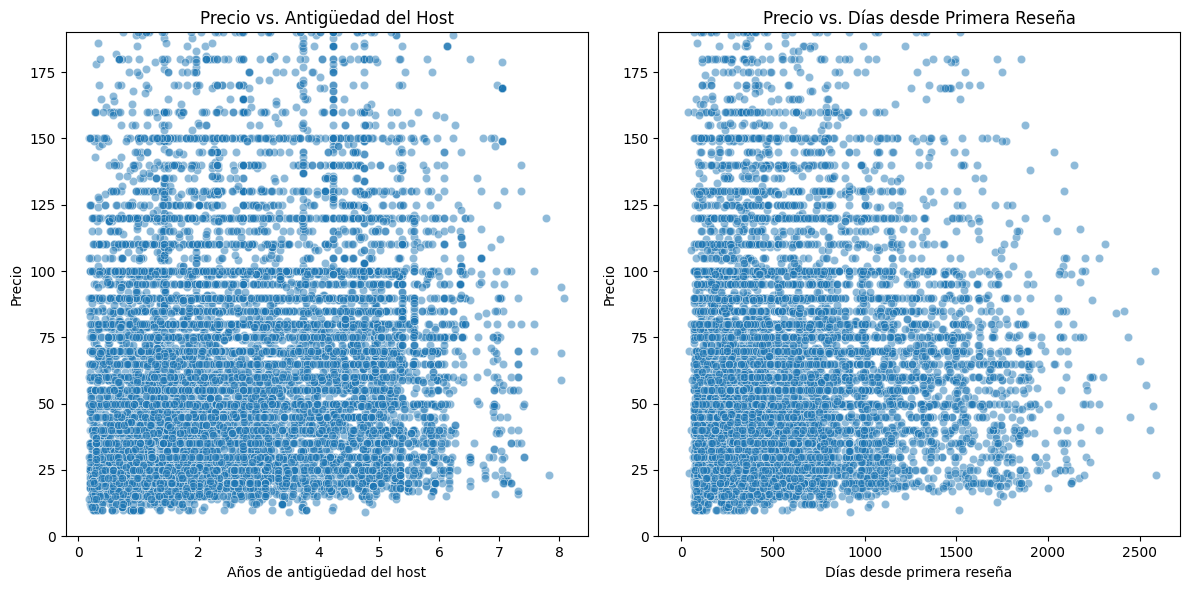


Columnas de fecha originales eliminadas: ['Host Since', 'First Review', 'Last Review']


In [27]:
# Analizo relación entre antigüedad y precio
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='host_age_years', y='Price', data=df_clean, alpha=0.5)
plt.title('Precio vs. Antigüedad del Host')
plt.xlabel('Años de antigüedad del host')
plt.ylabel('Precio')
plt.ylim(0, df_clean['Price'].quantile(0.95))

plt.subplot(1, 2, 2)
sns.scatterplot(x='days_since_first_review', y='Price', data=df_clean, alpha=0.5)
plt.title('Precio vs. Días desde Primera Reseña')
plt.xlabel('Días desde primera reseña')
plt.ylabel('Precio')
plt.ylim(0, df_clean['Price'].quantile(0.95))

plt.tight_layout()
plt.show()

# Elimino columnas originales de fecha
df_clean.drop(columns=date_cols, inplace=True)
print(f"\nColumnas de fecha originales eliminadas: {date_cols}")

EXTRACCIÓN DE INFORMACIÓN DE LISTAS

In [28]:
# Muestro ejemplos de listas en texto para entender su estructura
print("Ejemplos de listas en las columnas de texto:")
print("\nEjemplo de 'Amenities':")
print(df_clean['Amenities'].iloc[0])
print("\nEjemplo de 'Host Verifications':")
print(df_clean['Host Verifications'].iloc[0])

Ejemplos de listas en las columnas de texto:

Ejemplo de 'Amenities':
TV,Cable TV,Internet,Wireless Internet,Air conditioning,Pool,Free parking on premises,Heating,Family/kid friendly,Smoke detector,Carbon monoxide detector,Fire extinguisher,Essentials,Shampoo,Lock on bedroom door,24-hour check-in,Hangers,Hair dryer,Iron,Laptop friendly workspace,Self Check-In,Doorman Entry,Private entrance

Ejemplo de 'Host Verifications':
email,phone,reviews,kba


In [29]:
# Aseguro que las columnas relevantes sean string
df_clean['Amenities'] = df_clean['Amenities'].astype(str)
df_clean['Host Verifications'] = df_clean['Host Verifications'].astype(str)

# Creo variables de conteo
df_clean['n_amenities'] = df_clean['Amenities'].apply(lambda x: len(x.split(',')) if x.strip() != '' else 0)
df_clean['n_verifications'] = df_clean['Host Verifications'].apply(lambda x: len(x.split(',')) if x.strip() != '' else 0)

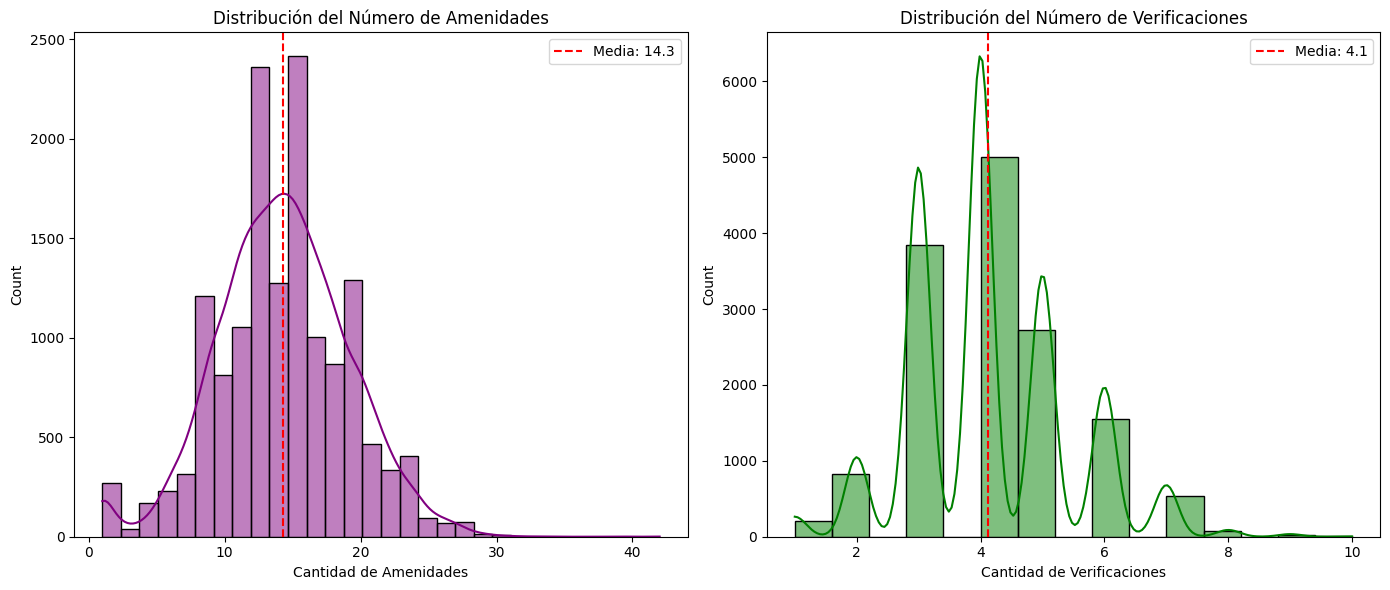

In [30]:
# Visualización: Distribución de conteos
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['n_amenities'], bins=30, kde=True, color='purple')
plt.title('Distribución del Número de Amenidades')
plt.xlabel('Cantidad de Amenidades')
plt.axvline(df_clean['n_amenities'].mean(), color='red', linestyle='--', 
           label=f'Media: {df_clean["n_amenities"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_clean['n_verifications'], bins=15, kde=True, color='green')
plt.title('Distribución del Número de Verificaciones')
plt.xlabel('Cantidad de Verificaciones')
plt.axvline(df_clean['n_verifications'].mean(), color='red', linestyle='--',
           label=f'Media: {df_clean["n_verifications"].mean():.1f}')
plt.legend()

plt.tight_layout()
plt.show()

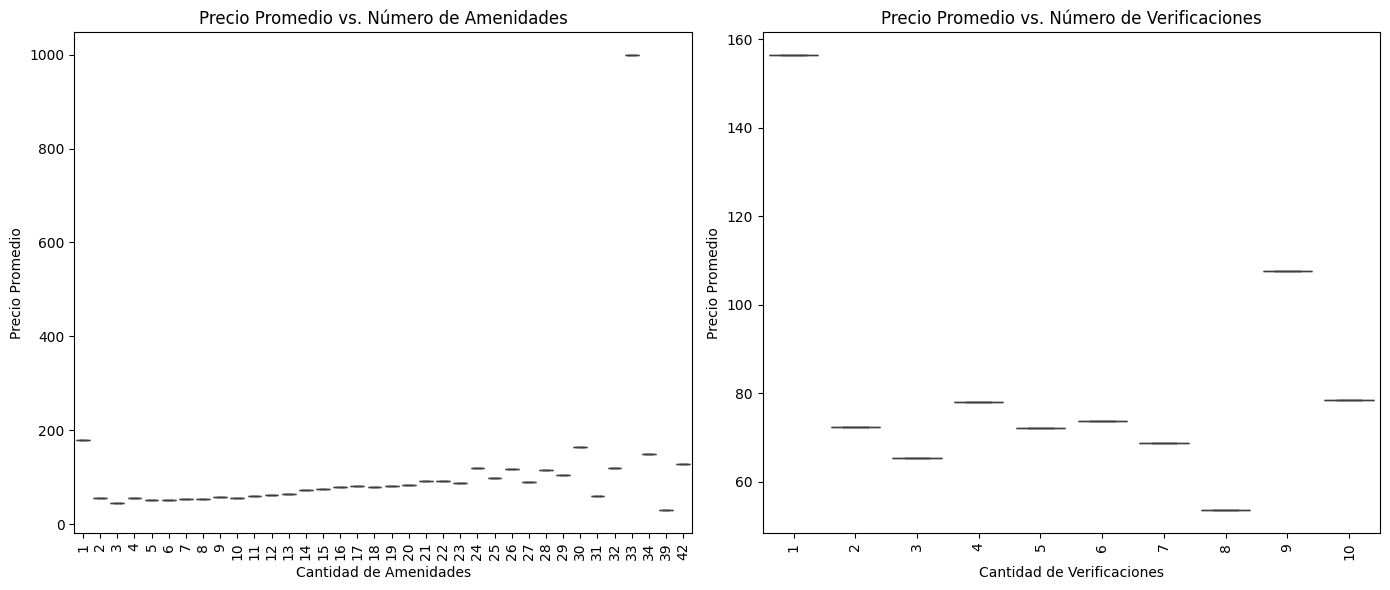


Estadísticas de las nuevas variables de conteo:
        n_amenities  n_verifications
count  14780.000000     14780.000000
mean      14.280920         4.118539
std        4.844211         1.286549
min        1.000000         1.000000
25%       11.000000         3.000000
50%       14.000000         4.000000
75%       17.000000         5.000000
max       42.000000        10.000000

Columnas originales de texto eliminadas después de extracción de características

Estructura del DataFrame después de procesar listas: (14780, 59)


,Name,Host ID,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Street,...,Calculated host listings count,Reviews per Month,Geolocation,Features,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
0,The Loft-Full Bath-Deck w/View,58386783,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,NaN,1.0,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",...,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",1.336071,457.0,107.0,0.958248,23,4
1,"Claris I, Friendly Rentals",102947901,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,"Barcelona, Barcelona 08010, Spain",...,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.594114,100.0,100.0,0.000000,7,4
2,"Style Terrace Red, Friendly Rentals",102947901,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,"Barcelona, Barcelona 08008, Spain",...,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.594114,NaN,NaN,NaN,7,4
3,Picasso Suite 1.4 Paseo de Gracia,131794,Damien,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,27.0,"Barcelona, Barcelona 08009, Spain",...,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re...",7.052704,422.0,103.0,0.873374,24,7
4,Smart City Centre Apartment II,54310958,Javier,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",...,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is...",1.418207,NaN,NaN,NaN,12,4


In [31]:
# Analizo relación entre estas características y el precio
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='n_amenities', y='Price', data=df_clean.groupby('n_amenities')['Price'].mean().reset_index())
plt.title('Precio Promedio vs. Número de Amenidades')
plt.xlabel('Cantidad de Amenidades')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.boxplot(x='n_verifications', y='Price', data=df_clean.groupby('n_verifications')['Price'].mean().reset_index())
plt.title('Precio Promedio vs. Número de Verificaciones')
plt.xlabel('Cantidad de Verificaciones')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Muestro estadísticas de las nuevas variables
print("\nEstadísticas de las nuevas variables de conteo:")
print(df_clean[['n_amenities', 'n_verifications']].describe())

# Elimino las columnas originales
df_clean.drop(columns=['Amenities', 'Host Verifications'], inplace=True)
print("\nColumnas originales de texto eliminadas después de extracción de características")

# Muestro la estructura actualizada del DataFrame
print(f"\nEstructura del DataFrame después de procesar listas: {df_clean.shape}")
display(df_clean.head())

IMPUTACIÓN DE VALORES FALTANTES

In [32]:
# Análisis inicial de valores faltantes antes de imputación
missing_before = df_clean.isnull().sum()
missing_pct_before = (missing_before / len(df_clean) * 100).round(2)

print("Valores faltantes antes de imputación:")
missing_summary = pd.DataFrame({
    'Conteo': missing_before,
    'Porcentaje': missing_pct_before
}).sort_values('Conteo', ascending=False)
display(missing_summary[missing_summary['Conteo'] > 0].head(10))

Valores faltantes antes de imputación:


,Conteo,Porcentaje
Cleaning Fee,6093,41.22
Neighbourhood,5229,35.38
Host Neighbourhood,3876,26.22
Review Scores Value,3341,22.60
Review Scores Location,3340,22.60
Review Scores Checkin,3337,22.58
Review Scores Accuracy,3326,22.50
Review Scores Communication,3320,22.46
Review Scores Cleanliness,3320,22.46
Review Scores Rating,3304,22.35


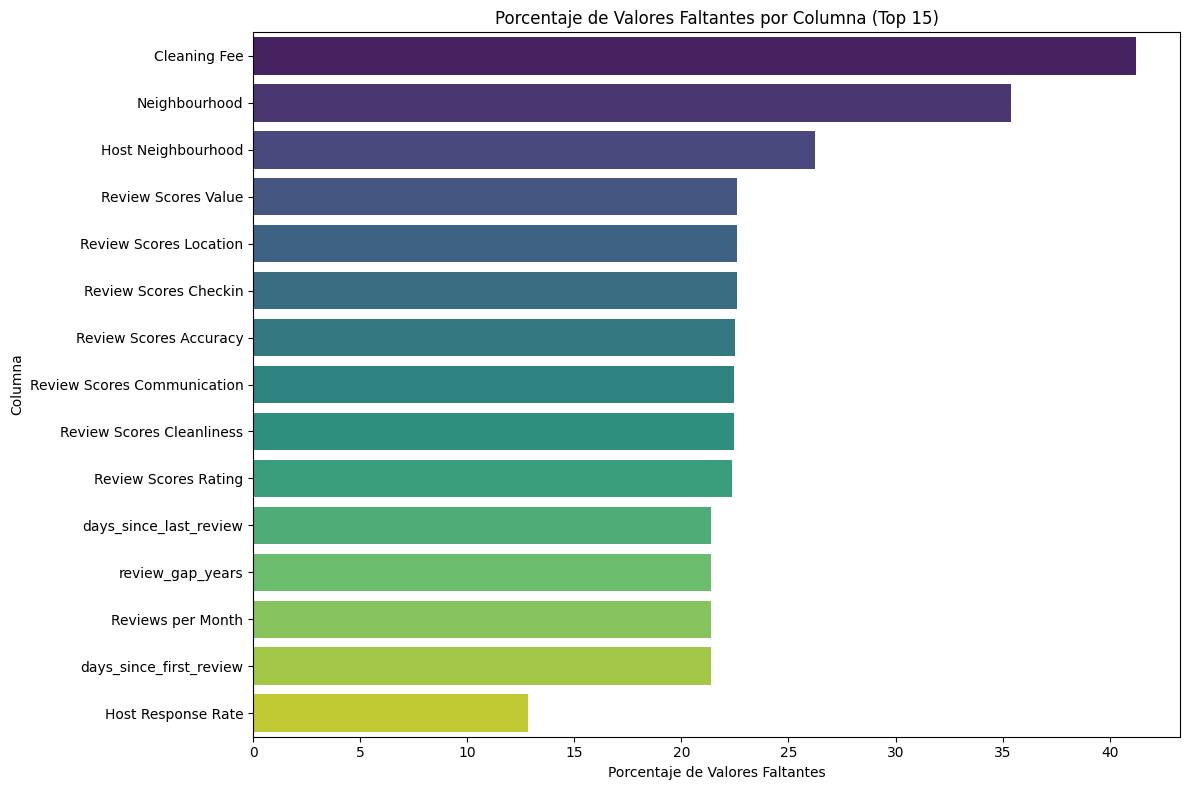

In [33]:
# Visualización de valores faltantes (top 15 columnas)
plt.figure(figsize=(12, 8))
cols_with_missing = missing_summary[missing_summary['Conteo'] > 0].index[:15]
missing_data = missing_summary.loc[cols_with_missing, 'Porcentaje']

# Crear un DataFrame explícito para evitar el warning
missing_df = pd.DataFrame({
    'Columna': cols_with_missing,
    'Porcentaje': missing_data.values
})

sns.barplot(data=missing_df, x='Porcentaje', y='Columna', hue='Columna', palette='viridis', legend=False, dodge=False)
plt.title('Porcentaje de Valores Faltantes por Columna (Top 15)')
plt.xlabel('Porcentaje de Valores Faltantes')
plt.ylabel('Columna')
plt.tight_layout()
plt.show()

In [34]:
# Guardar conteo antes de imputar
missing_before = df_clean.isnull().sum()
missing_pct_before = (missing_before / len(df_clean) * 100).round(2)

In [35]:
# Verificación y asignación segura de columnas por tipo
num_cols = [col for col in df_clean.select_dtypes(include=['float64', 'int64']).columns]

date_cols = ['Last Review', 'First Review', 'Host Since']
date_cols = [col for col in date_cols if col in df_clean.columns]

url_cols = [
    'XL Picture Url', 'Medium Url', 'Thumbnail Url',
    'Picture Url', 'Host Thumbnail Url', 'Host Picture Url'
]
url_cols = [col for col in url_cols if col in df_clean.columns]

rate_cols = ['Host Response Rate', 'Host Response Time']
rate_cols = [col for col in rate_cols if col in df_clean.columns]

text_cols = [
    'Neighbourhood', 'Neighbourhood Group Cleansed', 'Summary', 'Zipcode', 'Amenities',
    'State', 'Market', 'Host Location', 'City', 'Name', 'Description',
    'Features', 'Host Verifications', 'Host Name', 'Host Neighbourhood',
    'Street', 'Geolocation'
]
text_cols = [col for col in text_cols if col in df_clean.columns]

zero_cols = ['Cleaning Fee']
zero_cols = [col for col in zero_cols if col in df_clean.columns]

In [36]:
# Crear los imputadores
imp_mediana = SimpleImputer(strategy='median')
imp_missing = SimpleImputer(strategy='constant', fill_value='missing')
imp_no_image = SimpleImputer(strategy='constant', fill_value='no_image')
imp_unknown = SimpleImputer(strategy='constant', fill_value='unknown')
imp_empty = SimpleImputer(strategy='constant', fill_value='')
imp_zero = SimpleImputer(strategy='constant', fill_value=0)

In [37]:
# Aplicar imputación por tipo
if num_cols:
    df_clean[num_cols] = imp_mediana.fit_transform(df_clean[num_cols])

if date_cols:
    df_clean[date_cols] = df_clean[date_cols].astype(str)
    df_clean[date_cols] = imp_missing.fit_transform(df_clean[date_cols])

if url_cols:
    df_clean[url_cols] = imp_no_image.fit_transform(df_clean[url_cols])

if rate_cols:
    df_clean[rate_cols] = imp_unknown.fit_transform(df_clean[rate_cols])

if text_cols:
    df_clean[text_cols] = imp_empty.fit_transform(df_clean[text_cols])

if zero_cols:
    df_clean[zero_cols] = imp_zero.fit_transform(df_clean[zero_cols])

In [38]:
if 'Country' in df_clean.columns:
    most_common_country = df_clean['Country'].mode()[0]
    df_clean['Country'] = df_clean['Country'].fillna(most_common_country)
    print(f"Columna 'Country' imputada con valor más frecuente: {most_common_country}")

Columna 'Country' imputada con valor más frecuente: Spain


In [39]:
# Verificación después de la imputación
missing_after = df_clean.isnull().sum()
missing_pct_after = (missing_after / len(df_clean) * 100).round(2)

if missing_after.sum() > 0:
    print("\nValores faltantes restantes después de imputación:")
    missing_after_df = pd.DataFrame({
        'Conteo': missing_after,
        'Porcentaje': missing_pct_after
    }).sort_values('Conteo', ascending=False)
    display(missing_after_df[missing_after_df['Conteo'] > 0])
else:
    print("\nNo quedan valores faltantes en el dataset.")


No quedan valores faltantes en el dataset.


In [40]:
# Mostrar muestra del DataFrame final
print("\nMuestra del DataFrame después de imputación:")
display(df_clean.head())


Muestra del DataFrame después de imputación:


,Name,Host ID,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Street,...,Calculated host listings count,Reviews per Month,Geolocation,Features,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
0,The Loft-Full Bath-Deck w/View,58386783.0,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,,1.0,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",...,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",1.336071,457.0,107.0,0.958248,23.0,4.0
1,"Claris I, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,162.0,"Barcelona, Barcelona 08010, Spain",...,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.594114,100.0,100.0,0.000000,7.0,4.0
2,"Style Terrace Red, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,162.0,"Barcelona, Barcelona 08008, Spain",...,106.0,1.20,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.594114,454.0,97.0,0.752909,7.0,4.0
3,Picasso Suite 1.4 Paseo de Gracia,131794.0,Damien,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,27.0,"Barcelona, Barcelona 08009, Spain",...,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re...",7.052704,422.0,103.0,0.873374,24.0,7.0
4,Smart City Centre Apartment II,54310958.0,Javier,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",...,92.0,1.20,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is...",1.418207,454.0,97.0,0.752909,12.0,4.0


 Heatmap de valores faltantes después de la imputación


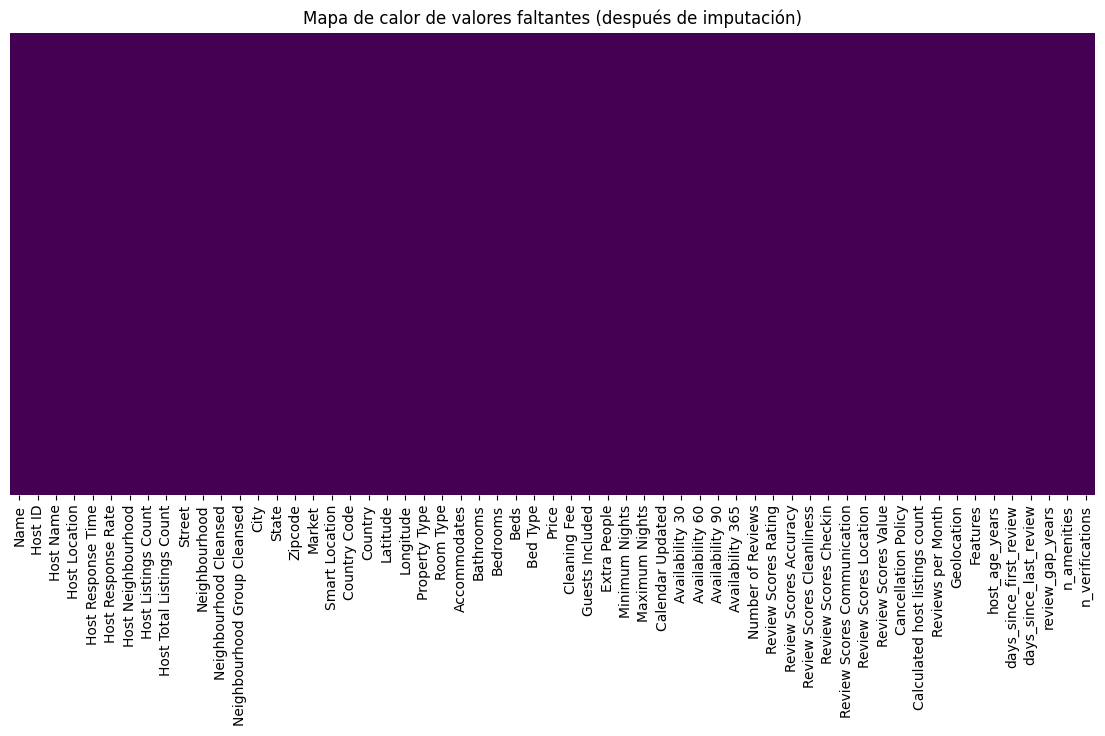

In [41]:
plt.figure(figsize=(14, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Mapa de calor de valores faltantes (después de imputación)')
plt.show()

ANÁLISIS DE COLINEALIDAD

In [42]:
# Selecciono variables numéricas para análisis
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Analizando colinealidad entre {len(numeric_cols)} variables numéricas")

# Calculo matriz de correlación
corr_matrix = df_clean[numeric_cols].corr()

Analizando colinealidad entre 35 variables numéricas


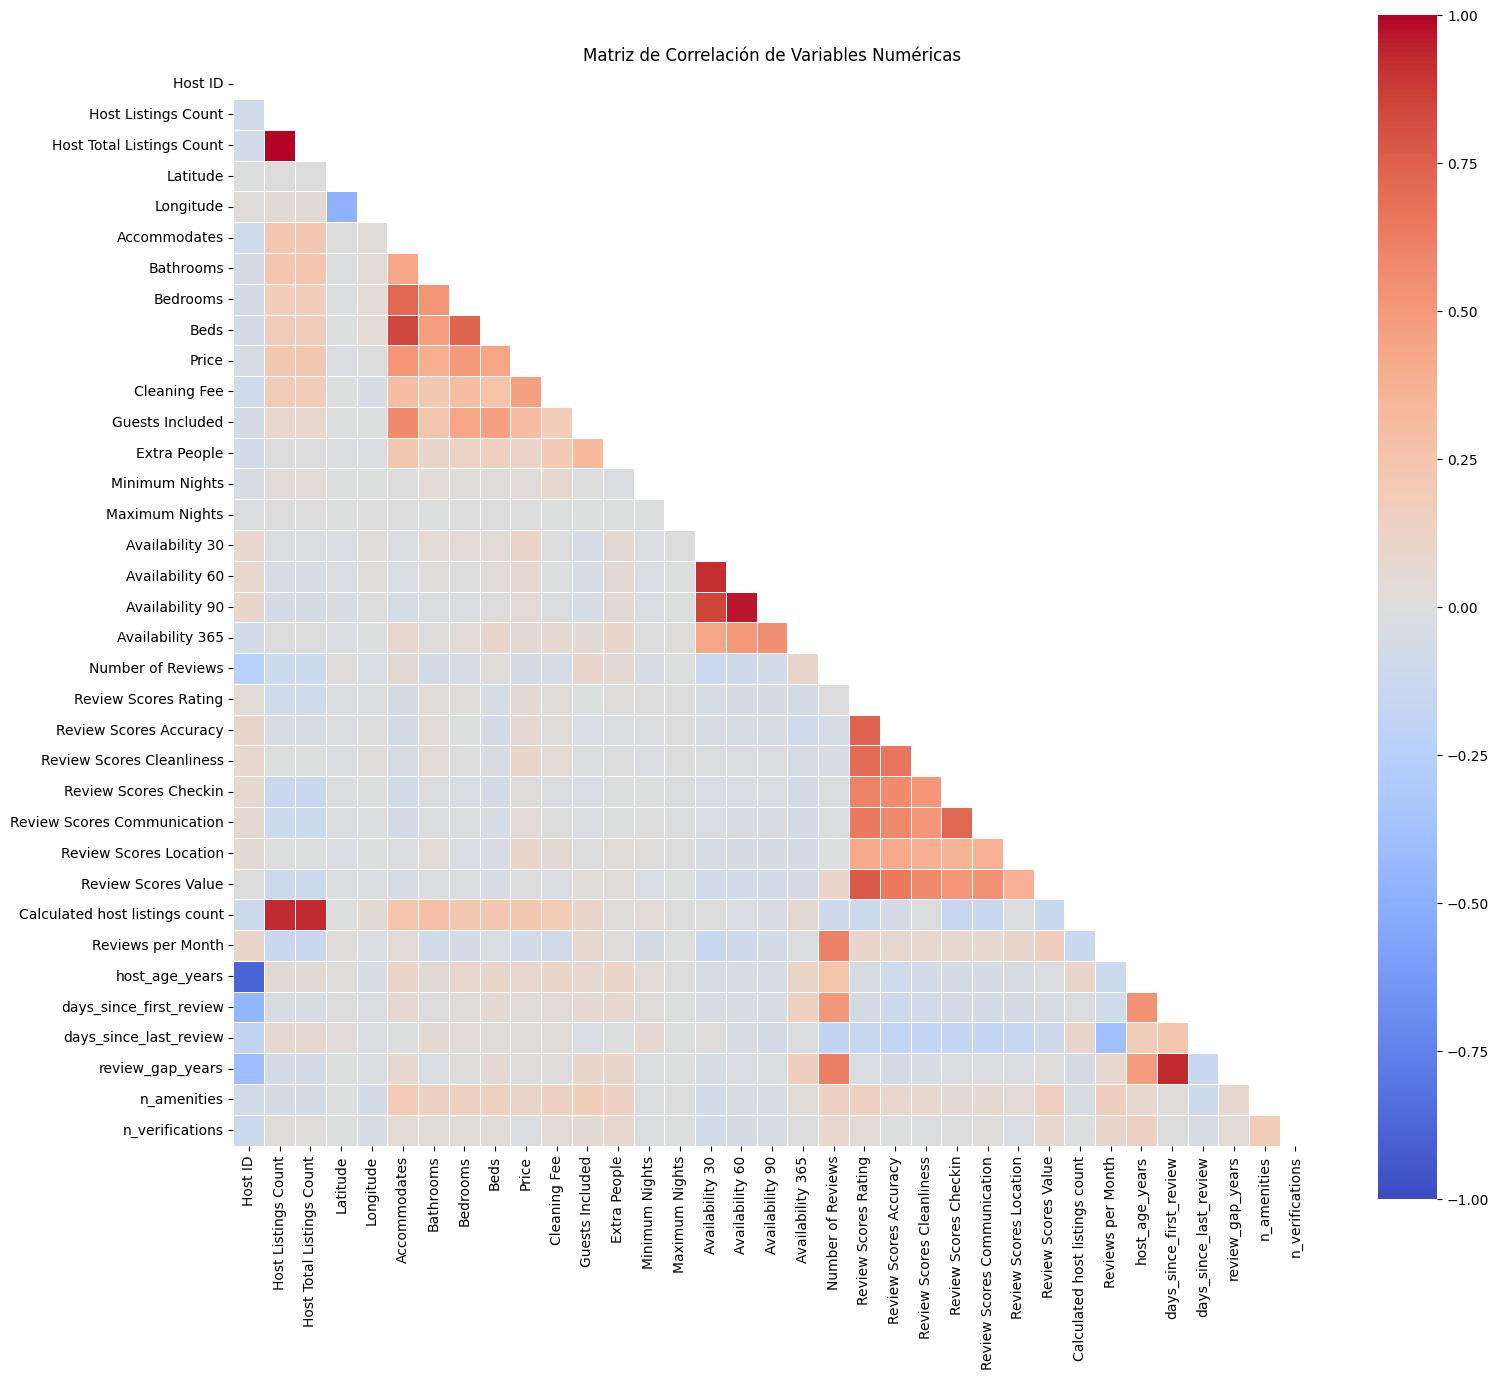

In [43]:
# Visualizo la matriz de correlación
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para mostrar solo el triángulo inferior
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, center=0, 
            linewidths=0.5, square=True, vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()


Pares de variables con alta correlación (>0.8):


,Variable 1,Variable 2,Correlación
0,Host Total Listings Count,Host Listings Count,1.000000
4,Availability 90,Availability 60,0.963501
8,review_gap_years,days_since_first_review,0.924247
5,Calculated host listings count,Host Listings Count,0.922842
6,Calculated host listings count,Host Total Listings Count,0.922842
2,Availability 60,Availability 30,0.921476
3,Availability 90,Availability 30,0.849756
1,Beds,Accommodates,0.837126
7,host_age_years,Host ID,-0.883670


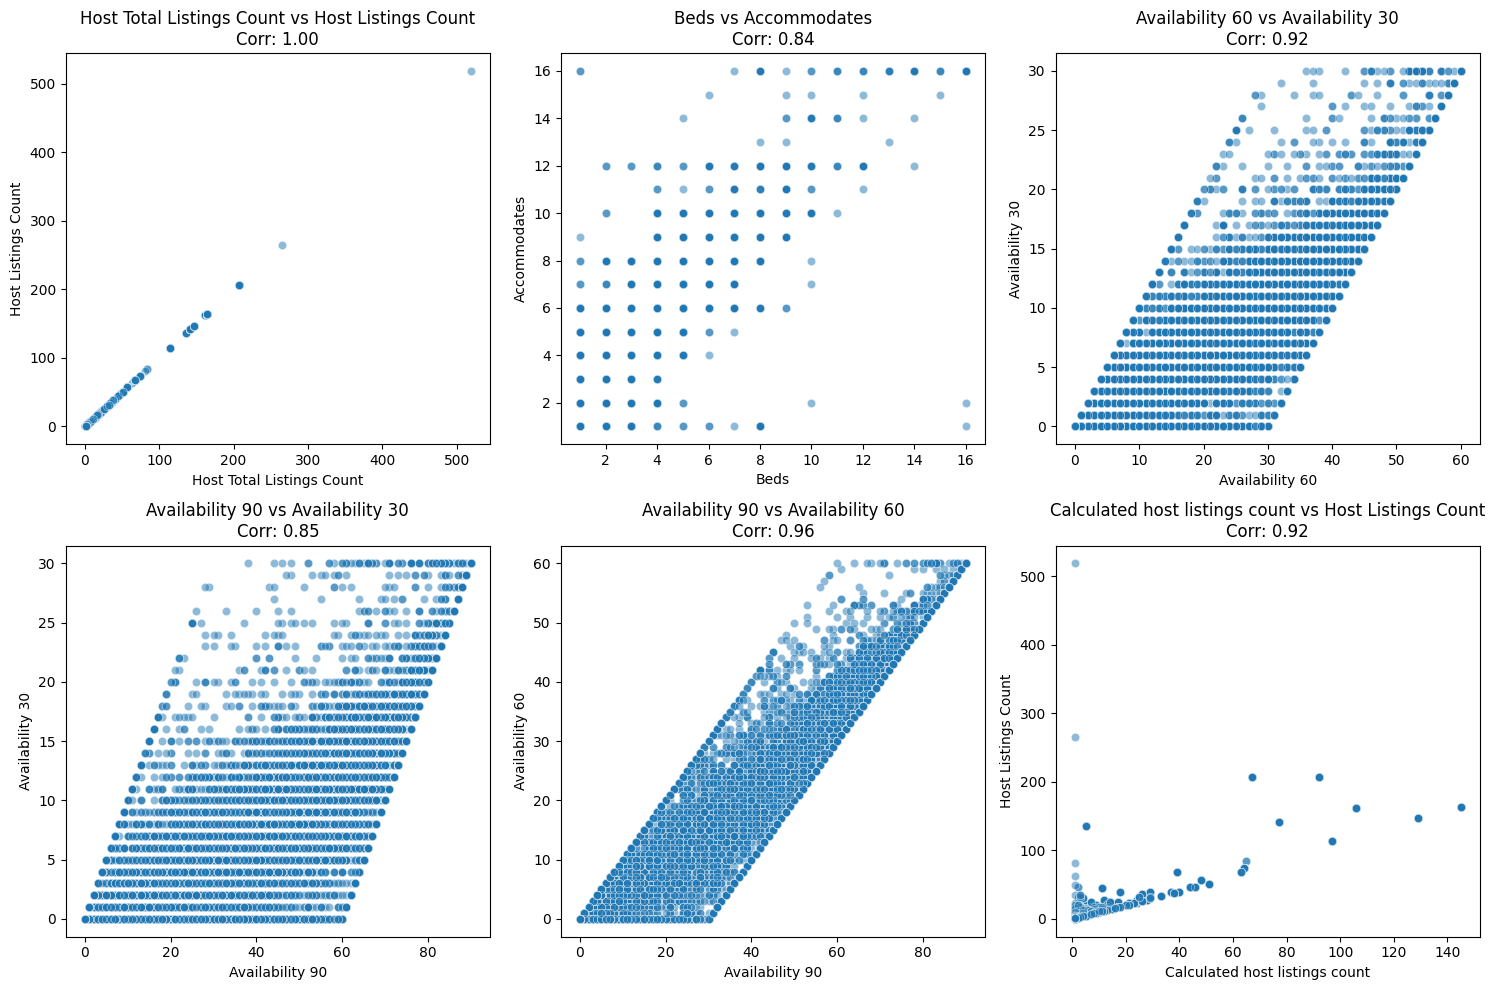

In [44]:
# Visualizo correlaciones altas (solo para análisis)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    high_corr_df = pd.DataFrame(high_corr, columns=['Variable 1', 'Variable 2', 'Correlación'])
    print("\nPares de variables con alta correlación (>0.8):")
    display(high_corr_df.sort_values('Correlación', ascending=False))
    
    # Visualización para los pares con mayor correlación
    if len(high_corr) > 0:
        plt.figure(figsize=(15, 10))
        for i, (var1, var2, corr) in enumerate(high_corr[:min(6, len(high_corr))], 1):
            plt.subplot(2, 3, i)
            sns.scatterplot(x=var1, y=var2, data=df_clean, alpha=0.5)
            plt.title(f'{var1} vs {var2}\nCorr: {corr:.2f}')
            plt.tight_layout()
        plt.tight_layout()
        plt.show()

In [45]:
# Identifico y elimino variables redundantes basadas en correlación
# Variables prácticamente duplicadas
cols_to_drop_colineal = [
    'Host Total Listings Count',  # Altamente correlacionada con Host Listings Count
    'Availability 30', 'Availability 60', 'Availability 90'  # Correlacionadas con Availability 365
]

existing_colineal = [col for col in cols_to_drop_colineal if col in df_clean.columns]
if existing_colineal:
    print(f"\nEliminando {len(existing_colineal)} variables colineales: {existing_colineal}")
    df_clean.drop(columns=existing_colineal, inplace=True)


Eliminando 4 variables colineales: ['Host Total Listings Count', 'Availability 30', 'Availability 60', 'Availability 90']


Durante la exploración encontramos varias relaciones bastante fuertes entre variables del dataset. Por ejemplo, no sorprende ver que a mayor número de camas (Beds), más personas se pueden alojar (Accommodates). La correlación entre estas dos es de 0.84, así que probablemente una de las dos es suficiente para el modelo (nos quedaríamos con la que aporte más valor o sea más interpretable).

También vimos que el número de propiedades que tiene un anfitrión (Calculated host listings count) está fuertemente correlacionado con el conteo oficial de publicaciones (Host Listings Count). Básicamente están diciendo lo mismo, así que tiene sentido dejar solo una para evitar duplicidad.

Otro caso curioso es la relación entre la antigüedad del anfitrión (host_age_years) y el ID del host. Tienen una correlación negativa bastante alta (-0.88), pero esto se explica porque los IDs se asignan secuencialmente, así que los hosts más nuevos tienen IDs más altos. Como el ID es solo un identificador y no aporta valor real al modelo, lo vamos a descartar.

Por último, vimos que el tiempo desde la primera reseña (days_since_first_review) y el “gap” entre reseñas (review_gap_years) también están muy relacionados. Eso tiene sentido porque mientras más tiempo haya pasado desde la primera reseña, más espacio hay entre una y otra. De nuevo, es mejor quedarnos con solo una.


Calculando el VIF (Multicolinealidad)

In [46]:
df_clean.head(5)

,Name,Host ID,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Street,Neighbourhood,...,Calculated host listings count,Reviews per Month,Geolocation,Features,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
0,The Loft-Full Bath-Deck w/View,58386783.0,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",,...,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",1.336071,457.0,107.0,0.958248,23.0,4.0
1,"Claris I, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08010, Spain",,...,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.594114,100.0,100.0,0.000000,7.0,4.0
2,"Style Terrace Red, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08008, Spain",,...,106.0,1.20,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.594114,454.0,97.0,0.752909,7.0,4.0
3,Picasso Suite 1.4 Paseo de Gracia,131794.0,Damien,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,"Barcelona, Barcelona 08009, Spain",,...,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re...",7.052704,422.0,103.0,0.873374,24.0,7.0
4,Smart City Centre Apartment II,54310958.0,Javier,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",L'Antiga Esquerra de l'Eixample,...,92.0,1.20,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is...",1.418207,454.0,97.0,0.752909,12.0,4.0


In [47]:
# Seleccionando de variables numéricas y eliminación de filas con nulos
X_vif = df_clean.select_dtypes(include=['float64', 'int64']).fillna(df_clean.median(numeric_only=True))

# Calculando del VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

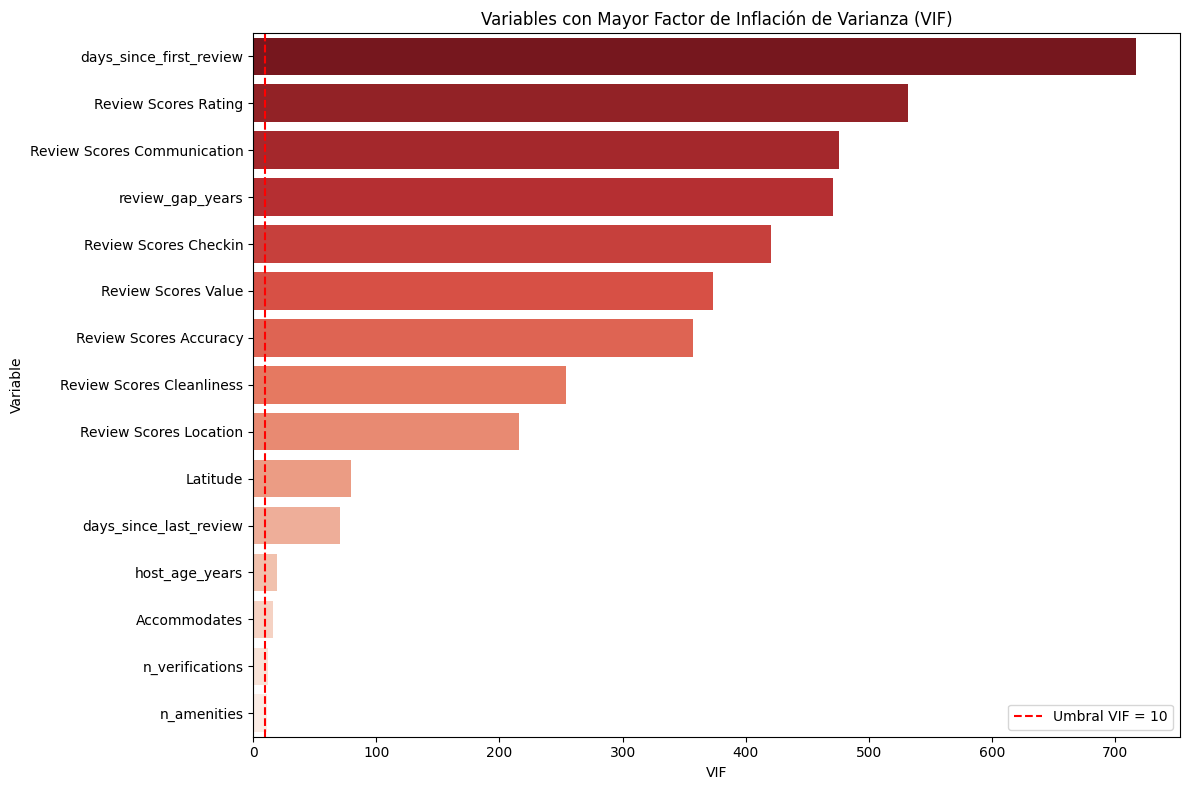

Variables con VIF > 10:
['Latitude', 'Accommodates', 'Beds', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'host_age_years', 'days_since_first_review', 'days_since_last_review', 'review_gap_years', 'n_amenities', 'n_verifications']


In [48]:
# Visualización de los 15 VIF más altos
plt.figure(figsize=(12, 8))
vif_top = vif_data.sort_values('VIF', ascending=False).head(15)

# Crear copia con índice como columna para evitar problemas con hue
vif_plot_df = vif_top.reset_index(drop=True).copy()
vif_plot_df['Variable'] = vif_plot_df['Variable'].astype(str)
sns.barplot(data=vif_plot_df, x='VIF', y='Variable', hue='Variable', palette='Reds_r', legend=False, dodge=False)

plt.title('Variables con Mayor Factor de Inflación de Varianza (VIF)')
plt.axvline(x=10, color='red', linestyle='--', label='Umbral VIF = 10')
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar variables con VIF > 10
high_vif_vars = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()
print("Variables con VIF > 10:")
print(high_vif_vars)

In [49]:
df_clean = df_clean.copy()

# --- Índice de capacidad ---
cap_cols = ['Accommodates', 'Beds', 'Bedrooms']
if all(col in df_clean.columns for col in cap_cols):
    cap_data = df_clean[cap_cols].fillna(0)
    cap_scaled = MinMaxScaler().fit_transform(cap_data)
    df_clean['capacity_index'] = cap_scaled.mean(axis=1)
    df_clean.drop(columns=cap_cols, inplace=True)
    print(f"Índice 'capacity_index' creado y eliminadas: {cap_cols}")
else:
    print("No se pudo crear 'capacity_index': faltan columnas.")

# --- Índice de reseñas (fechas) ---
review_cols = ['days_since_first_review', 'days_since_last_review', 'review_gap_years']
if all(col in df_clean.columns for col in review_cols):
    review_data = df_clean[review_cols].fillna(df_clean[review_cols].median(numeric_only=True))
    review_scaled = MinMaxScaler().fit_transform(review_data)
    df_clean['review_index'] = PCA(n_components=1).fit_transform(review_scaled)
    df_clean.drop(columns=review_cols, inplace=True)
    print(f"Índice 'review_index' creado y eliminadas: {review_cols}")
else:
    print("No se pudo crear 'review_index': faltan columnas.")

# --- Índice del host ---
host_cols = ['host_age_years', 'n_verifications', 'n_amenities']
if all(col in df_clean.columns for col in host_cols):
    host_data = df_clean[host_cols].fillna(df_clean[host_cols].median(numeric_only=True))
    host_scaled = MinMaxScaler().fit_transform(host_data)
    df_clean['host_index'] = PCA(n_components=1).fit_transform(host_scaled)
    df_clean.drop(columns=host_cols, inplace=True)
    print(f"Índice 'host_index' creado y eliminadas: {host_cols}")
else:
    print("No se pudo crear 'host_index': faltan columnas.")

Índice 'capacity_index' creado y eliminadas: ['Accommodates', 'Beds', 'Bedrooms']
Índice 'review_index' creado y eliminadas: ['days_since_first_review', 'days_since_last_review', 'review_gap_years']
Índice 'host_index' creado y eliminadas: ['host_age_years', 'n_verifications', 'n_amenities']


In [50]:
# Seleccionar solo columnas numéricas y excluir la variable objetivo
X = df_clean.select_dtypes(include=['float64', 'int64'])
X = X.drop(columns=['Price'], errors='ignore')
X = X.fillna(X.median(numeric_only=True))

In [51]:
# Calcular VIF
vif_data_final = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

In [52]:
# Mostrar resultado
print("VIF final después de crear índices y limpiar colinealidad:")
display(vif_data_final)

VIF final después de crear índices y limpiar colinealidad:


,Variable,VIF
12,Review Scores Rating,528.677853
16,Review Scores Communication,472.516109
15,Review Scores Checkin,418.789315
13,Review Scores Accuracy,339.936496
18,Review Scores Value,315.626461
14,Review Scores Cleanliness,240.449792
17,Review Scores Location,205.129341
2,Latitude,74.922468
0,Host ID,9.238189
19,Calculated host listings count,8.463861


In [53]:
# Consolidar review_scores si no se ha hecho
review_score_cols = [
    'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness',
    'Review Scores Checkin', 'Review Scores Communication',
    'Review Scores Location', 'Review Scores Value'
]

review_score_cols = [col for col in review_score_cols if col in df_clean.columns]

if review_score_cols:
    df_clean['review_scores_mean'] = df_clean[review_score_cols].mean(axis=1)
    df_clean.drop(columns=review_score_cols, inplace=True)
    print(f"Consolidado 'review_scores_mean' (eliminadas {len(review_score_cols)} columnas)")

Consolidado 'review_scores_mean' (eliminadas 7 columnas)


In [54]:
# Eliminar columnas redundantes
cols_to_remove = ['Latitude', 'Host ID']
df_clean.drop(columns=[col for col in cols_to_remove if col in df_clean.columns], inplace=True)
print(f"Columnas eliminadas: {[col for col in cols_to_remove if col in df_clean.columns]}")

Columnas eliminadas: []


In [55]:
# Recalcular VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_clean.select_dtypes(include=['float64', 'int64']).drop(columns=['Price', 'Price_log'], errors='ignore')
X = X.fillna(X.median(numeric_only=True))

vif_data_final = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

print("\nVIF final tras consolidación de Review Scores y limpieza de columnas redundantes:")
display(vif_data_final)


VIF final tras consolidación de Review Scores y limpieza de columnas redundantes:


,Variable,VIF
15,review_scores_mean,9.975704
10,Calculated host listings count,8.412009
0,Host Listings Count,7.899495
2,Bathrooms,6.858569
11,Reviews per Month,4.971508
9,Number of Reviews,4.737072
12,capacity_index,4.438824
4,Guests Included,4.322315
8,Availability 365,3.598909
3,Cleaning Fee,2.947844


Este resultado del VIF final refleja que la consolidación de los Review Scores y la eliminación de columnas redundantes ha sido efectiva para reducir la colinealidad dentro del dataset. Ninguna variable supera el umbral crítico de 10, lo que indica que ya no existe colinealidad severa. La variable con mayor VIF es review_scores_mean (9.97), lo cual es esperable ya que condensa información de múltiples columnas previamente altamente correlacionadas. Le siguen Calculated host listings count y Host Listings Count con valores alrededor de 8, lo que sugiere una relación fuerte entre ambas, por lo que convendría conservar solo una. El resto de las variables se encuentra en rangos totalmente aceptables, con muchas por debajo de 5 e incluso algunas cercanas a 1, como host_index, Minimum Nights, Maximum Nights y Longitude. Esto confirma que el dataset está estadísticamente limpio y listo para el modelado, sin riesgo significativo de distorsión causada por colinealidad entre los predictores.

Revisamos la distribución de 'Price' (variable objetivo) para evaluar si es necesario transformarla antes del modelado

In [56]:
# Estadísticas básicas y asimetría
original_skew = df_clean['Price'].skew()
price_stats = df_clean['Price'].describe()
print(f"\nEstadísticas de Price antes de transformación:\n{price_stats}")
print(f"Asimetría (skew) original: {original_skew:.2f}")


Estadísticas de Price antes de transformación:
count    14780.000000
mean        73.540122
std         72.023341
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64
Asimetría (skew) original: 4.37


(0.0, 190.0)

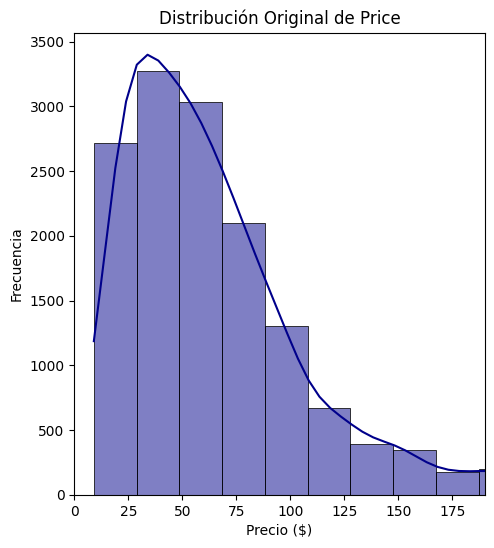

In [57]:
# Visualización de distribución original y transformada
plt.figure(figsize=(18, 6))

# Histograma original
plt.subplot(1, 3, 1)
sns.histplot(df_clean['Price'], bins=50, kde=True, color='darkblue')
plt.title('Distribución Original de Price')
plt.xlabel('Precio ($)')
plt.ylabel('Frecuencia')
plt.xlim(0, df_clean['Price'].quantile(0.95))

(0.0, 190.0)

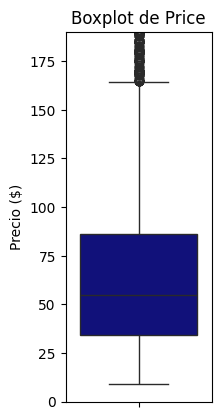

In [58]:
# Boxplot original
plt.subplot(1, 3, 2)
sns.boxplot(y=df_clean['Price'], color='darkblue')
plt.title('Boxplot de Price')
plt.ylabel('Precio ($)')
plt.ylim(0, df_clean['Price'].quantile(0.95))

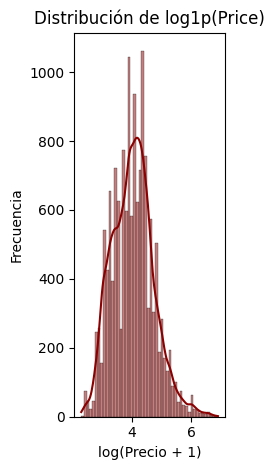

In [59]:
# Histograma transformado
plt.subplot(1, 3, 3)
sns.histplot(np.log1p(df_clean['Price']), bins=50, kde=True, color='darkred')
plt.title('Distribución de log1p(Price)')
plt.xlabel('log(Precio + 1)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


Asimetría después de transformación: 0.39
Reducción de asimetría: 3.98

 Justificación: La variable 'Price' tenía alta asimetría y fue transformada con log1p para aproximarla a una distribución normal. Esto mejora el desempeño de modelos lineales y reduce el impacto de valores extremos.


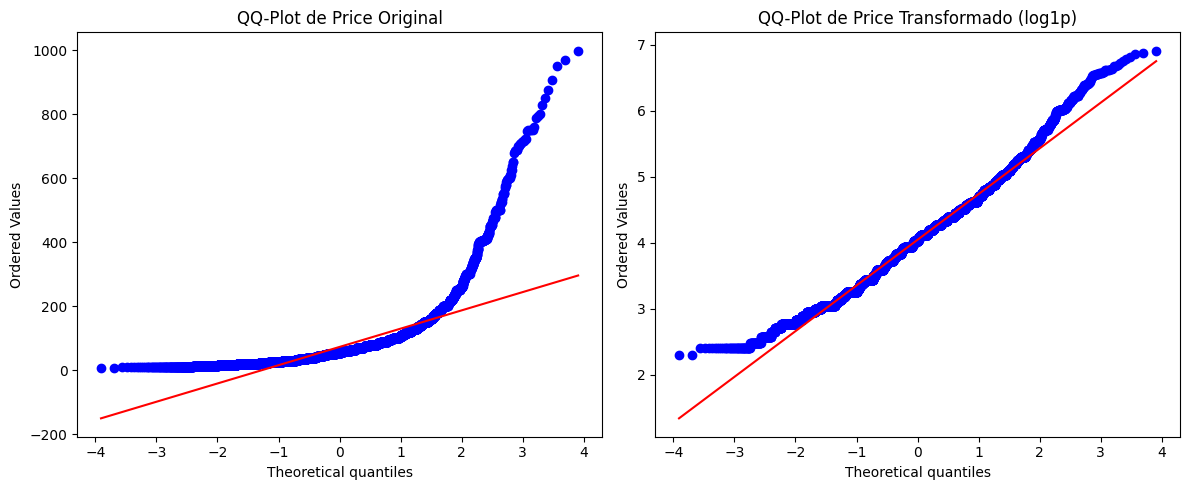

In [60]:
# Aplicamos la transformación logarítmica (log1p para evitar log(0))
df_clean['Price_log'] = np.log1p(df_clean['Price'])

# Verificamos la nueva asimetría
log_skew = df_clean['Price_log'].skew()
print(f"\nAsimetría después de transformación: {log_skew:.2f}")
print("Reducción de asimetría:", round(original_skew - log_skew, 2))

# Justificación
if abs(original_skew) > 1 and abs(log_skew) < abs(original_skew):
    print("\n Justificación: La variable 'Price' tenía alta asimetría y fue transformada con log1p para aproximarla a una distribución normal. Esto mejora el desempeño de modelos lineales y reduce el impacto de valores extremos.")
else:
    print("\n La transformación logarítmica no redujo significativamente la asimetría. Puede no ser necesaria.")

# QQ-Plots para comparar normalidad
from scipy import stats
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(df_clean['Price'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot de Price Original')

plt.subplot(1, 2, 2)
stats.probplot(df_clean['Price_log'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot de Price Transformado (log1p)')

plt.tight_layout()
plt.show()

## Transformación de Precio con log1p()

La variable `Price` presentaba una distribución fuertemente asimétrica (asimetría: 4.37), lo cual es común en precios donde hay muchos valores bajos y pocos extremadamente altos. 

Para mejorar su comportamiento estadístico y facilitar el aprendizaje de los modelos (especialmente lineales), aplicamos una transformación logarítmica (`log1p`).

**Resultados:**
- La asimetría bajó de 4.37 a 0.39
- La distribución se volvió mucho más simétrica
- El QQ-plot posterior muestra una clara alineación con la normal

Esta transformación reduce el impacto de valores extremos y mejora la estabilidad y desempeño del modelo predictivo.

In [61]:
# Verificando que Price y Price_log están altamente correlacionadas
correlation = df_clean[['Price', 'Price_log']].corr().iloc[0, 1]
print(f" Correlación entre Price y Price_log: {correlation:.4f}")

 Correlación entre Price y Price_log: 0.8416


Esto confirma que la transformación logarítmica conserva la estructura del precio original

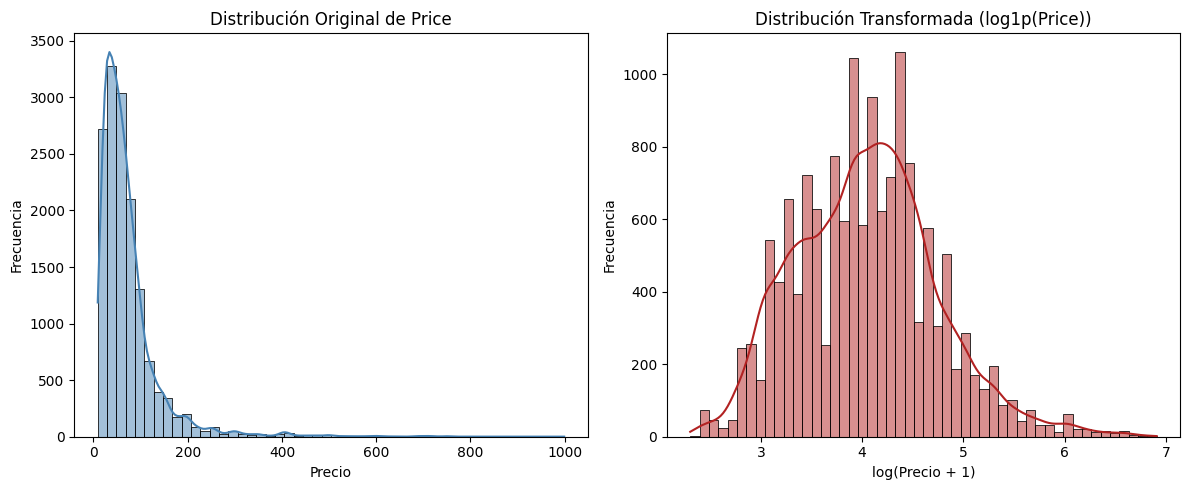

In [62]:
# Comparando visualmente las distribuciones antes y después de la transformación
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['Price'], kde=True, bins=50, color='steelblue')
plt.title('Distribución Original de Price')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['Price_log'], kde=True, bins=50, color='firebrick')
plt.title('Distribución Transformada (log1p(Price))')
plt.xlabel('log(Precio + 1)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [63]:
# Evaluando si hay otras variables numéricas con alta asimetría (skew)
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
skewed_cols = []

for col in numeric_cols:
    if col in ['Price', 'Price_log']:
        continue  # Ya fueron tratadas

    skewness = df_clean[col].skew()
    if abs(skewness) > 1:
        skewed_cols.append((col, skewness))

# Mostrando las variables más sesgadas
skewed_df = pd.DataFrame(skewed_cols, columns=['Variable', 'Asimetría']).sort_values('Asimetría', ascending=False)

print("\n Variables numéricas con alta asimetría (|skew| > 1):")
display(skewed_df)


 Variables numéricas con alta asimetría (|skew| > 1):


,Variable,Asimetría
6,Maximum Nights,112.819507
5,Minimum Nights,59.995203
4,Extra People,10.397449
2,Cleaning Fee,7.746806
0,Host Listings Count,4.278840
8,Calculated host listings count,4.011173
3,Guests Included,3.952247
1,Bathrooms,3.446105
7,Number of Reviews,3.189607
10,capacity_index,2.412839


In [64]:
# Variables que transformaremos con log1p
log_transform_cols = [
    'Maximum Nights',
    'Minimum Nights',
    'Extra People',
    'Cleaning Fee',
    'Number of Reviews',
    'Reviews per Month'
]

# Crear nuevas columnas con sufijo _log
for col in log_transform_cols:
    if col in df_clean.columns:
        df_clean[col + '_log'] = np.log1p(df_clean[col])
        print(f" Transformado {col} → {col}_log")
    else:
        print(f" {col} no encontrado en el DataFrame")

# Opcional: mostrar las nuevas columnas transformadas
df_clean[[col + '_log' for col in log_transform_cols if col + '_log' in df_clean.columns]].head()

 Transformado Maximum Nights → Maximum Nights_log
 Transformado Minimum Nights → Minimum Nights_log
 Transformado Extra People → Extra People_log
 Transformado Cleaning Fee → Cleaning Fee_log
 Transformado Number of Reviews → Number of Reviews_log
 Transformado Reviews per Month → Reviews per Month_log


,Maximum Nights_log,Minimum Nights_log,Extra People_log,Cleaning Fee_log,Number of Reviews_log,Reviews per Month_log
0,7.026427,1.098612,0.000000,3.258097,3.761200,1.504077
1,7.026427,0.693147,3.806662,3.713572,0.693147,0.620576
2,7.026427,0.693147,3.761200,4.110874,0.000000,0.788457
3,7.026427,1.098612,3.688879,4.382027,2.639057,0.737164
4,7.026427,1.098612,0.000000,4.025352,0.000000,0.788457


## Transformación logarítmica de variables altamente sesgadas

Varias variables presentaban distribuciones fuertemente asimétricas (skew > 1), lo cual puede afectar el desempeño de modelos sensibles a la forma de las variables.

Aplicamos `log1p()` a las siguientes variables para suavizar su distribución y reducir el impacto de valores extremos:
- Maximum Nights
- Minimum Nights
- Extra People
- Cleaning Fee
- Number of Reviews
- Reviews per Month

Se crearon nuevas columnas con sufijo `_log` que serán evaluadas en el modelado.

In [65]:
pd.set_option('display.max_columns', None)

In [66]:
df_clean.head(3)

,Name,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Longitude,Property Type,Room Type,Bathrooms,Bed Type,Price,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features,capacity_index,review_index,host_index,review_scores_mean,Price_log,Maximum Nights_log,Minimum Nights_log,Extra People_log,Cleaning Fee_log,Number of Reviews_log,Reviews per Month_log
0,The Loft-Full Bath-Deck w/View,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",,78733,,Austin,TX,78733,Austin,"Austin, TX",US,United States,-97.863277,Loft,Entire home/apt,1.0,Real Bed,58.0,25.0,1.0,0.0,2.0,1125.0,today,281.0,42.0,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",0.055556,-0.035272,-0.158192,22.571429,4.077537,7.026427,1.098612,0.000000,3.258097,3.761200,1.504077
1,"Claris I, Friendly Rentals",Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08010, Spain",,la Dreta de l'Eixample,Eixample,Barcelona,Barcelona,08010,Barcelona,"Barcelona, Spain",ES,Spain,2.172625,Apartment,Entire home/apt,1.0,Real Bed,70.0,40.0,2.0,44.0,1.0,1125.0,today,309.0,1.0,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.100000,-0.231137,-0.282005,19.428571,4.262680,7.026427,0.693147,3.806662,3.713572,0.693147,0.620576
2,"Style Terrace Red, Friendly Rentals",Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08008, Spain",,la Dreta de l'Eixample,Eixample,Barcelona,Barcelona,08008,Barcelona,"Barcelona, Spain",ES,Spain,2.162173,Apartment,Entire home/apt,1.0,Real Bed,70.0,60.0,2.0,42.0,1.0,1125.0,today,291.0,0.0,super_strict_30,106.0,1.20,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.100000,-0.057442,-0.282005,21.857143,4.262680,7.026427,0.693147,3.761200,4.110874,0.000000,0.788457


In [67]:
# Muestro un ejemplo de cómo se ve el precio ahora
sample_prices = pd.DataFrame({
    'Price_Original': [50, 100, 200, 500, 1000],
    'Price_Log': np.log1p([50, 100, 200, 500, 1000])
})
print("\nEjemplo de transformación para algunos precios:")
display(sample_prices)


Ejemplo de transformación para algunos precios:


,Price_Original,Price_Log
0,50,3.931826
1,100,4.615121
2,200,5.303305
3,500,6.216606
4,1000,6.908755


Crear versión limpia y libre de NaN solo con variables numéricas útiles

In [68]:
# Crear dataset limpio solo con variables numéricas
df_model_final = df_clean.select_dtypes(include=['float64', 'int64']).copy()

# Imputar nulos con la mediana solo de columnas numéricas
df_model_final = df_model_final.fillna(df_model_final.median(numeric_only=True))

# Verificar que no quedan nulos
print("¿Hay NaN en df_model_final?", df_model_final.isnull().values.any())

# Guardar
df_model_final.to_csv('data/processed/df_model_final.csv', index=False)
print("Dataset limpio para modelado guardado en 'data/processed/df_model_final.csv'")

¿Hay NaN en df_model_final? False
Dataset limpio para modelado guardado en 'data/processed/df_model_final.csv'


CODIFICACIÓN DE VARIABLES CATEGÓRICAS

In [69]:
# Crear una copia del dataframe base para codificación
df_encoded = df_clean.copy()

# Columnas categóricas a excluir manualmente (irrelevantes o con cardinalidad alta esperada)
excluir_cols = [
    'Name', 'Host Name', 'Street', 'Host Location', 'Zipcode', 'Geolocation',
    'Smart Location', 'Country', 'Country Code', 'Market', 'Host Neighbourhood'
]

# Detectar columnas categóricas que sí queremos evaluar
cat_cols = df_encoded.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col not in excluir_cols]

print(f"Detectadas {len(cat_cols)} columnas categóricas útiles (excluidas {len(excluir_cols)} irrelevantes):")
display(pd.DataFrame({
    'Columna': cat_cols,
    'Valores Únicos': [df_encoded[col].nunique() for col in cat_cols],
    'Ejemplo': [df_encoded[col].dropna().iloc[0] if df_encoded[col].notna().any() else 'NaN' for col in cat_cols]
}).sort_values('Valores Únicos'))

# Separar columnas con baja y alta cardinalidad
one_hot_cols = [col for col in cat_cols if df_encoded[col].nunique() <= 10]
high_card_cols = [col for col in cat_cols if df_encoded[col].nunique() > 10]

print(f"\nColumnas para One-Hot Encoding ({len(one_hot_cols)}): {one_hot_cols}")
print(f"Columnas descartadas por alta cardinalidad ({len(high_card_cols)}): {high_card_cols}")

# Aplicar One-Hot Encoding (sin afectar df_clean)
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True)

# Eliminar columnas de alta cardinalidad (solo si no se van a codificar)
df_encoded.drop(columns=high_card_cols, inplace=True, errors='ignore')

print(f"\nDimensiones finales del df_encoded: {df_encoded.shape}")
print("Ejemplo de nuevas columnas dummy creadas:")
print([col for col in df_encoded.columns if any(prefix in col for prefix in one_hot_cols)][:10])

Detectadas 13 columnas categóricas útiles (excluidas 11 irrelevantes):


,Columna,Valores Únicos,Ejemplo
8,Room Type,3,Entire home/apt
0,Host Response Time,5,within an hour
9,Bed Type,5,Real Bed
11,Cancellation Policy,8,moderate
7,Property Type,22,Loft
4,Neighbourhood Group Cleansed,50,
10,Calendar Updated,57,today
1,Host Response Rate,70,100.0
12,Features,89,"Host Is Superhost,Host Has Profile Pic,Host Id..."
6,State,103,TX



Columnas para One-Hot Encoding (4): ['Host Response Time', 'Room Type', 'Bed Type', 'Cancellation Policy']
Columnas descartadas por alta cardinalidad (9): ['Host Response Rate', 'Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City', 'State', 'Property Type', 'Calendar Updated', 'Features']

Dimensiones finales del df_encoded: (14780, 52)
Ejemplo de nuevas columnas dummy creadas:
['Host Response Time_unknown', 'Host Response Time_within a day', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Room Type_Private room', 'Room Type_Shared room', 'Bed Type_Couch', 'Bed Type_Futon', 'Bed Type_Pull-out Sofa', 'Bed Type_Real Bed']


ESCALADO DE VARIABLES Y PREPARACIÓN FINAL

In [70]:
# Definir variable objetivo
y = df_encoded['Price_log']

# Crear copia del dataset
df_model_scaled = df_encoded.copy()

# Identificar columnas numéricas a escalar (excluyendo Price_log)
numeric_cols = df_model_scaled.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Price_log']

# Aplicar StandardScaler
scaler = StandardScaler()
df_model_scaled[numeric_cols] = scaler.fit_transform(df_model_scaled[numeric_cols])

# Guardar el scaler para usarlo en datos futuros
joblib.dump(scaler, 'scaler.pkl')
print("Escalador guardado como 'scaler.pkl'")

Escalador guardado como 'scaler.pkl'


In [71]:
# Separar X e y
y = df_encoded['Price_log']
X = df_encoded.drop(columns='Price_log')

# Identificar columnas numéricas dentro de X
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Seleccionar un subconjunto de variables numéricas para visualizar
variables_to_plot = numeric_cols[:3]  # Puedes ajustar este número

print(f"Variables numéricas seleccionadas para visualización: {variables_to_plot}")

Variables numéricas seleccionadas para visualización: ['Host Listings Count', 'Longitude', 'Bathrooms']


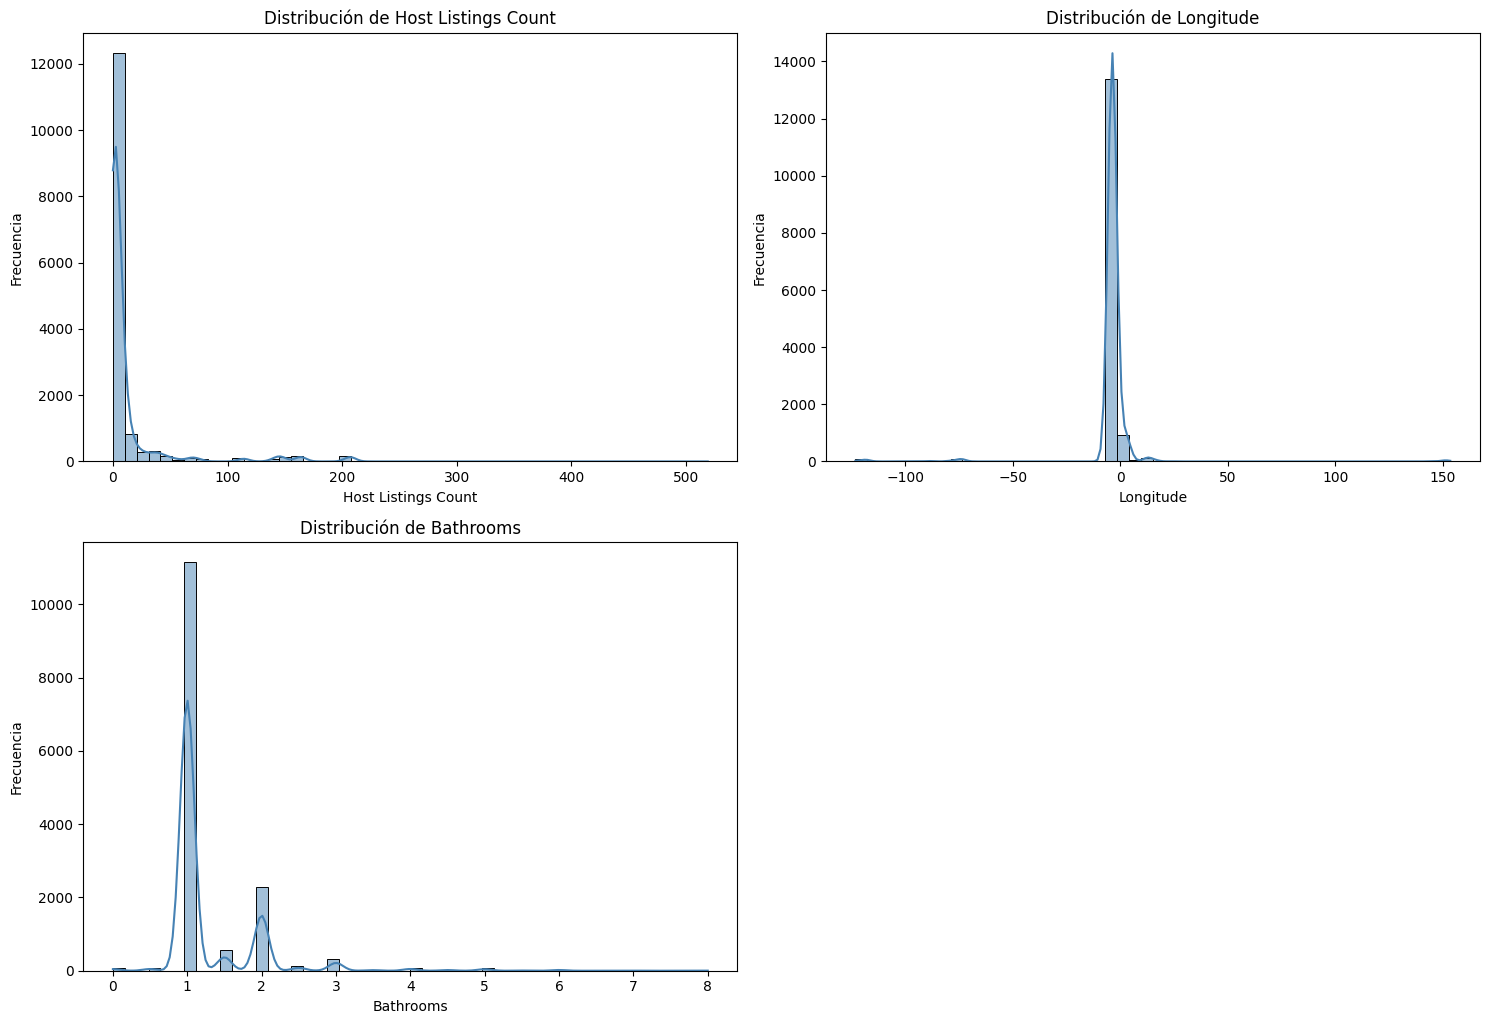

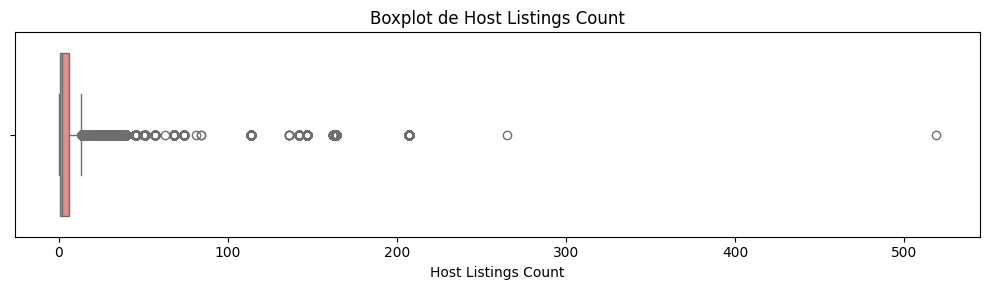

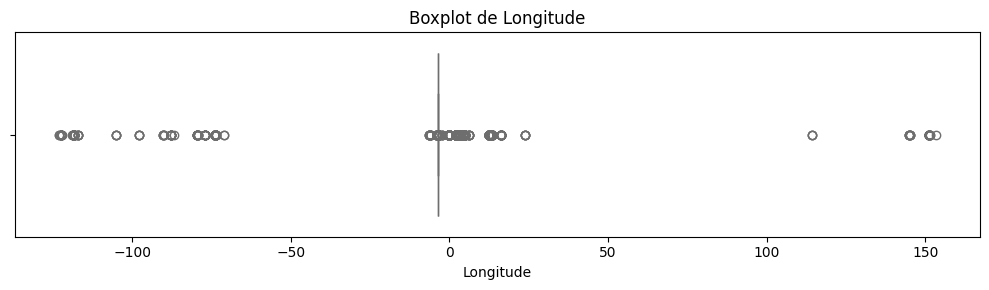

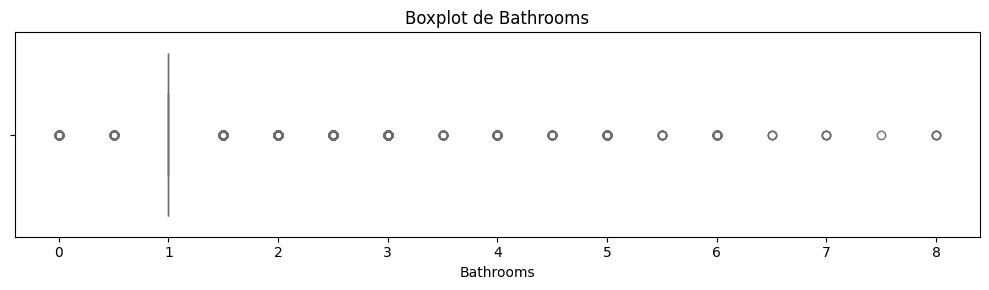

In [72]:
# Histograma y KDE para las variables seleccionadas
plt.figure(figsize=(15, 5 * len(variables_to_plot)))
for i, var in enumerate(variables_to_plot, 1):
    plt.subplot(len(variables_to_plot), 2, i)
    sns.histplot(X[var], bins=50, kde=True, color='steelblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Boxplots para observar outliers y dispersión
for var in variables_to_plot:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=X[var], color='lightcoral')
    plt.title(f'Boxplot de {var}')
    plt.tight_layout()
    plt.show()

Antes del escalado, todas las variables tenían rangos muy diferentes entre sí. Por ejemplo, Cleaning Fee podía ir desde 0 hasta más de 600 dólares, mientras que Guests Included normalmente no pasaba de 4 o 5 personas, y Bathrooms tenía una distribución muy marcada en valores discretos (1, 1.5, 2, etc.). Esto genera un desbalance cuando se usan modelos que interpretan la magnitud de los valores numéricos (como regresiones o redes neuronales).

Después del escalado, todas las variables ahora están centradas y estandarizadas en torno a cero, con una dispersión mucho más comparable. Aunque los outliers siguen estando allí (porque el escalado no los elimina, solo ajusta la escala), su peso relativo se normaliza frente al resto de los datos. Esto es bueno, porque evita que una sola variable con un rango grande como Cleaning Fee domine el aprendizaje del modelo.

También se nota que el shape general de las distribuciones no cambió: seguimos teniendo picos, colas y outliers. Lo que cambió fue la escala, y eso es exactamente lo que queríamos.

EVALUACIÓN FINAL DEL DATAFRAME

In [74]:
# Dimensiones del DataFrame
print(f"\nTamaño del DataFrame: {df_encoded.shape[0]} filas, {df_encoded.shape[1]} columnas")


Tamaño del DataFrame: 14780 filas, 52 columnas


In [75]:
# Tipos de datos
print("\nTipos de datos por tipo:")
print(df_encoded.dtypes.value_counts())


Tipos de datos por tipo:
float64    24
uint8      17
object     11
dtype: int64


In [77]:
# Conteo de variables numéricas (excluyendo la target)
num_vars = df_encoded.select_dtypes(include='number').shape[1] - (1 if 'Price_log' in df_encoded.columns else 0)
print(f"Cantidad de variables numéricas predictoras: {num_vars}")

Cantidad de variables numéricas predictoras: 40


In [78]:
# Estadísticas descriptivas de las variables numéricas
print("\nEstadísticas descriptivas:")
display(df_encoded.describe().T)


Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
Host Listings Count,14780.0,1.251150e+01,34.087092,0.000000,1.000000,2.000000,6.000000,519.000000
Longitude,14780.0,-3.858041e+00,14.123146,-123.131344,-3.707604,-3.700785,-3.684057,153.371427
Bathrooms,14780.0,1.280683e+00,0.657514,0.000000,1.000000,1.000000,1.000000,8.000000
Price,14780.0,7.354012e+01,72.023341,9.000000,34.000000,55.000000,86.000000,999.000000
Cleaning Fee,14780.0,2.899986e+01,23.908403,0.000000,20.000000,25.000000,30.000000,662.000000
Guests Included,14780.0,1.589986e+00,1.182550,0.000000,1.000000,1.000000,2.000000,16.000000
Extra People,14780.0,7.690460e+00,12.971352,0.000000,0.000000,0.000000,15.000000,500.000000
Minimum Nights,14780.0,3.050474e+00,12.266517,1.000000,1.000000,2.000000,3.000000,1125.000000
Maximum Nights,14780.0,9.451687e+02,8439.321218,1.000000,365.000000,1125.000000,1125.000000,1000000.000000
Availability 365,14780.0,2.021045e+02,127.886822,0.000000,78.000000,239.000000,319.000000,365.000000


In [79]:
# Correlación con la variable objetivo
if 'Price_log' in df_encoded.columns:
    corr_matrix = df_encoded.corr(numeric_only=True)['Price_log'].drop('Price_log').sort_values(ascending=False)
    
    print("\nVariables más correlacionadas con Price_log:")
    display(corr_matrix.head(10))

    print("\nVariables menos correlacionadas con Price_log:")
    display(corr_matrix.tail(10))


Variables más correlacionadas con Price_log:


Price                             0.841609
capacity_index                    0.568127
Cleaning Fee_log                  0.481859
Cleaning Fee                      0.419134
Guests Included                   0.375605
Bathrooms                         0.282843
Host Listings Count               0.245416
Calculated host listings count    0.232949
Cancellation Policy_strict        0.168324
Minimum Nights_log                0.148967
Name: Price_log, dtype: float64


Variables menos correlacionadas con Price_log:


Number of Reviews_log          -0.017826
Longitude                      -0.018535
Bed Type_Pull-out Sofa         -0.024506
Cancellation Policy_moderate   -0.030619
Bed Type_Futon                 -0.032333
Reviews per Month_log          -0.044722
Reviews per Month              -0.049700
Host Response Time_unknown     -0.061317
Room Type_Shared room          -0.151969
Room Type_Private room         -0.615408
Name: Price_log, dtype: float64

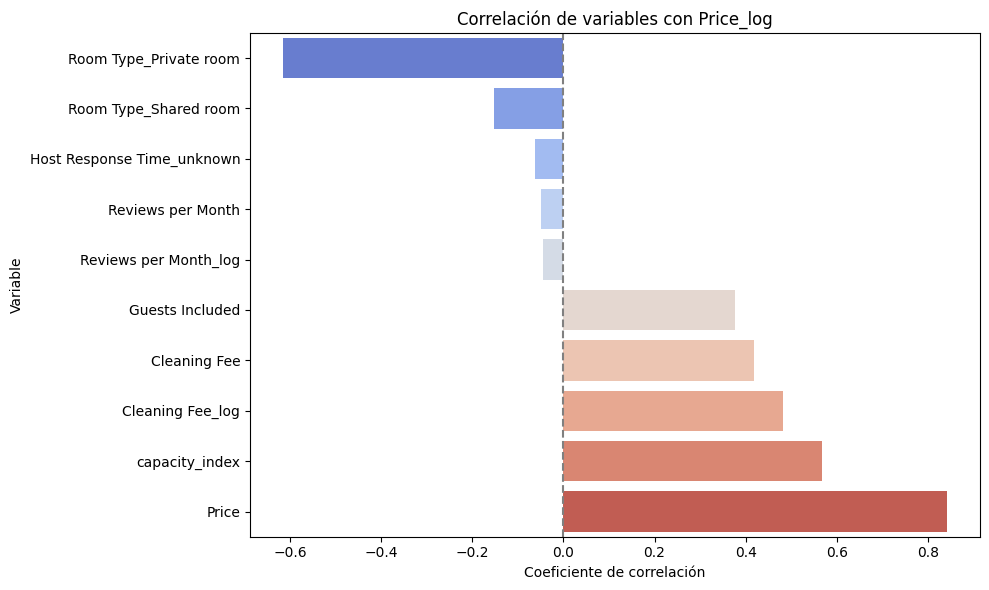

In [81]:
# Asegurarse de que Price_log esté en el DataFrame

if 'Price_log' in df_encoded.columns:
    # Calcular correlación con Price_log
    corr_matrix = df_encoded.corr(numeric_only=True)['Price_log'].drop('Price_log').sort_values()

    # Tomar las 5 más negativas y 5 más positivas
    top_negative = corr_matrix.head(5)
    top_positive = corr_matrix.tail(5)
    combined = pd.concat([top_negative, top_positive])

    # Crear DataFrame para graficar
    corr_plot_df = combined.reset_index()
    corr_plot_df.columns = ['Variable', 'Correlacion']

    # Visualización sin warning
    plt.figure(figsize=(10, 6))
    sns.barplot(data=corr_plot_df, x='Correlacion', y='Variable', hue='Variable', palette='coolwarm', dodge=False, legend=False)
    plt.title("Correlación de variables con Price_log")
    plt.xlabel("Coeficiente de correlación")
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

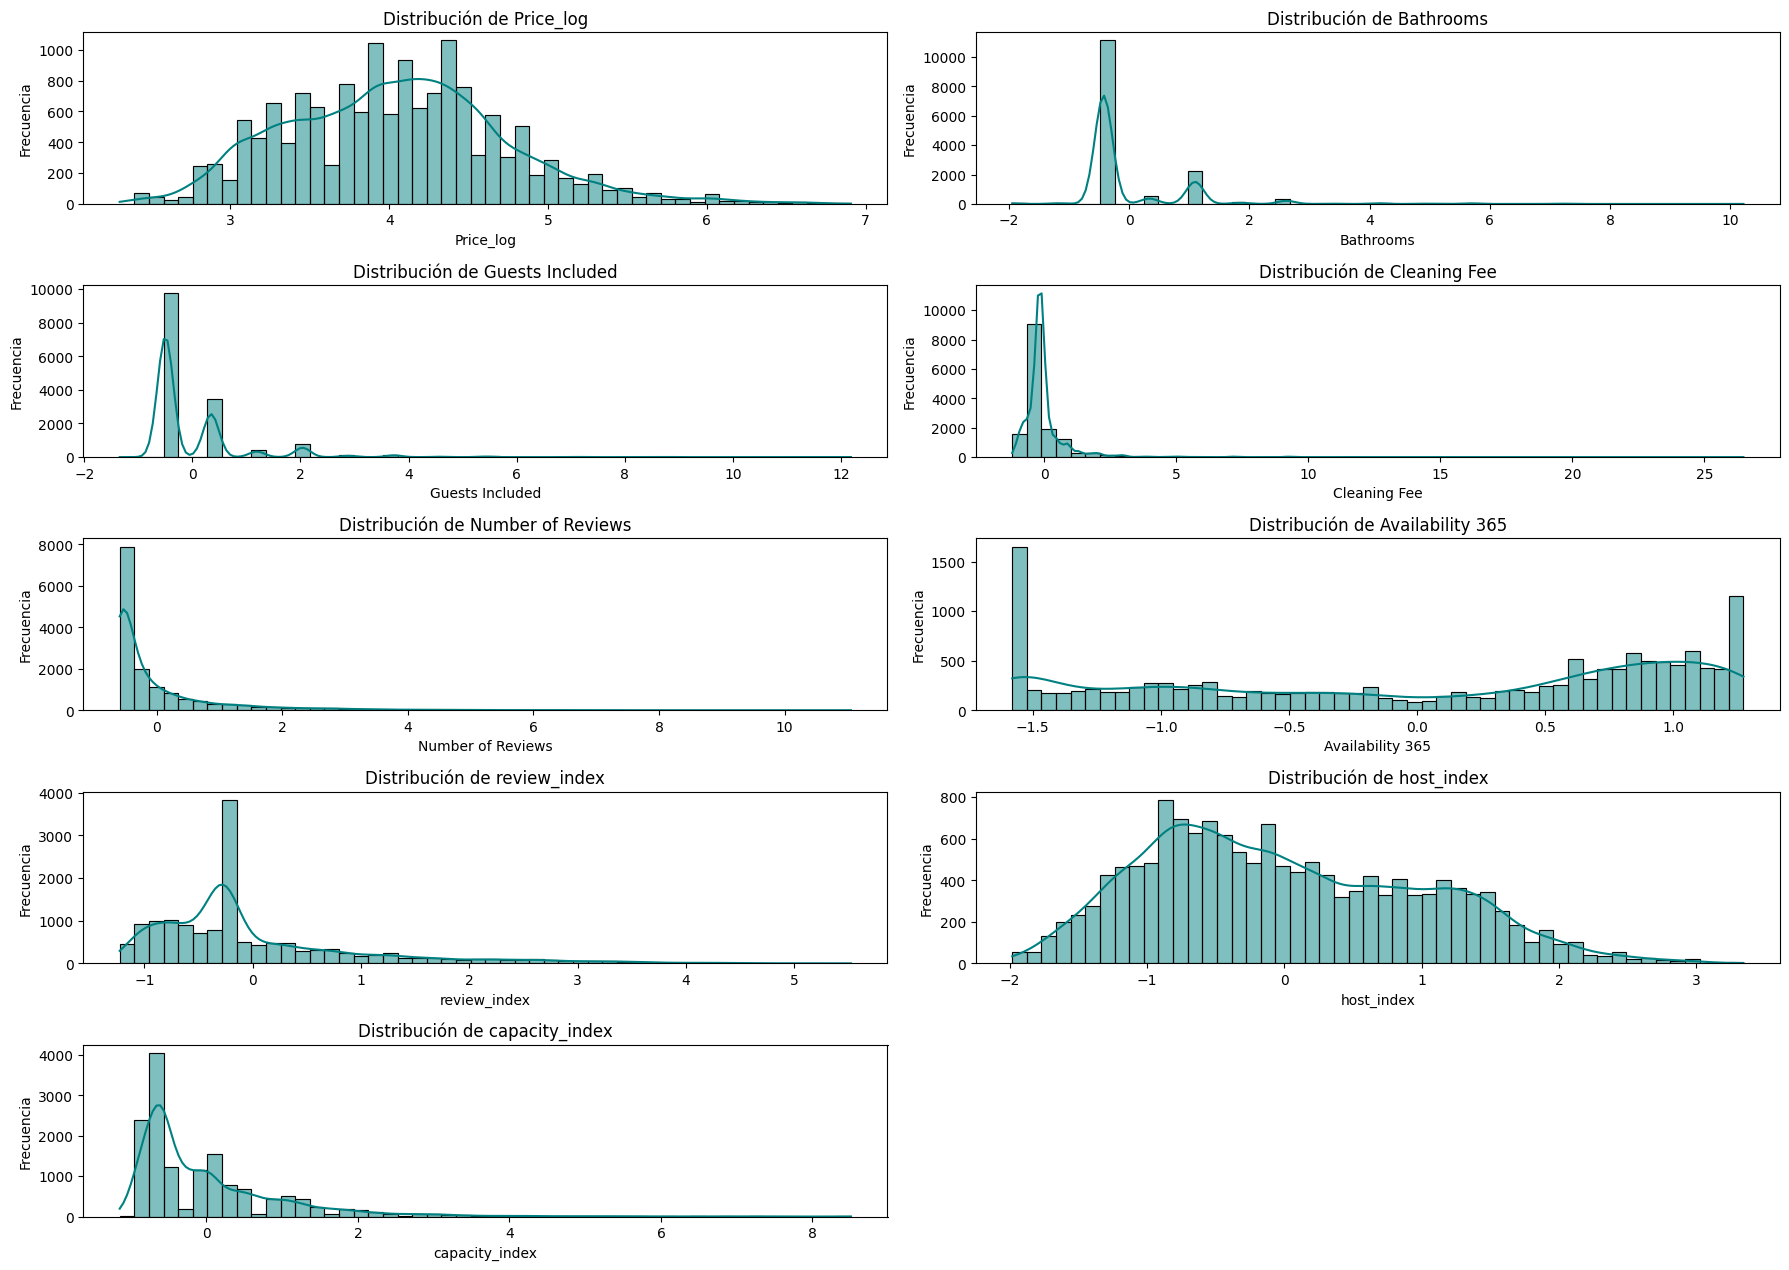

In [82]:
# Variables clave (ajusta según tu df_model_scaled)
key_vars = [
    'Price_log', 'Bathrooms', 'Guests Included', 'Cleaning Fee',
    'Number of Reviews', 'Availability 365',
    'review_index', 'host_index', 'capacity_index'
]

# Filtrar solo las que existen en el dataset
key_vars = [col for col in key_vars if col in df_model_scaled.columns]

# Histogramas
plt.figure(figsize=(18, len(key_vars) * 2.5))
for i, col in enumerate(key_vars):
    plt.subplot(len(key_vars), 2, i + 1)
    sns.histplot(df_model_scaled[col], kde=True, bins=50, color='teal')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Las gráficas muestran la distribución de las variables más importantes que alimentarán el modelo. Aquí algunas observaciones clave:
	•	Price_log ya presenta una distribución mucho más simétrica y cercana a una normal, lo cual es excelente como variable objetivo para modelos lineales.
	•	Bathrooms, Guests Included, Cleaning Fee y Number of Reviews siguen teniendo colas derechas marcadas, pero al estar escaladas, su magnitud ya no distorsiona el modelo. Si bien hay outliers, ahora están balanceados en la escala estandarizada.
	•	Availability 365 tiene una distribución interesante: parece casi uniforme, con picos en los extremos. Esto indica que hay propiedades que están o casi siempre disponibles o casi nunca. El modelo puede aprovechar esta información para asociarla a precios.
	•	Los índices compuestos (review_index, host_index, capacity_index) capturan bastante variabilidad. Aunque todavía tienen algo de asimetría, esto es esperable al haber sido generados con componentes principales o combinaciones de variables originales.


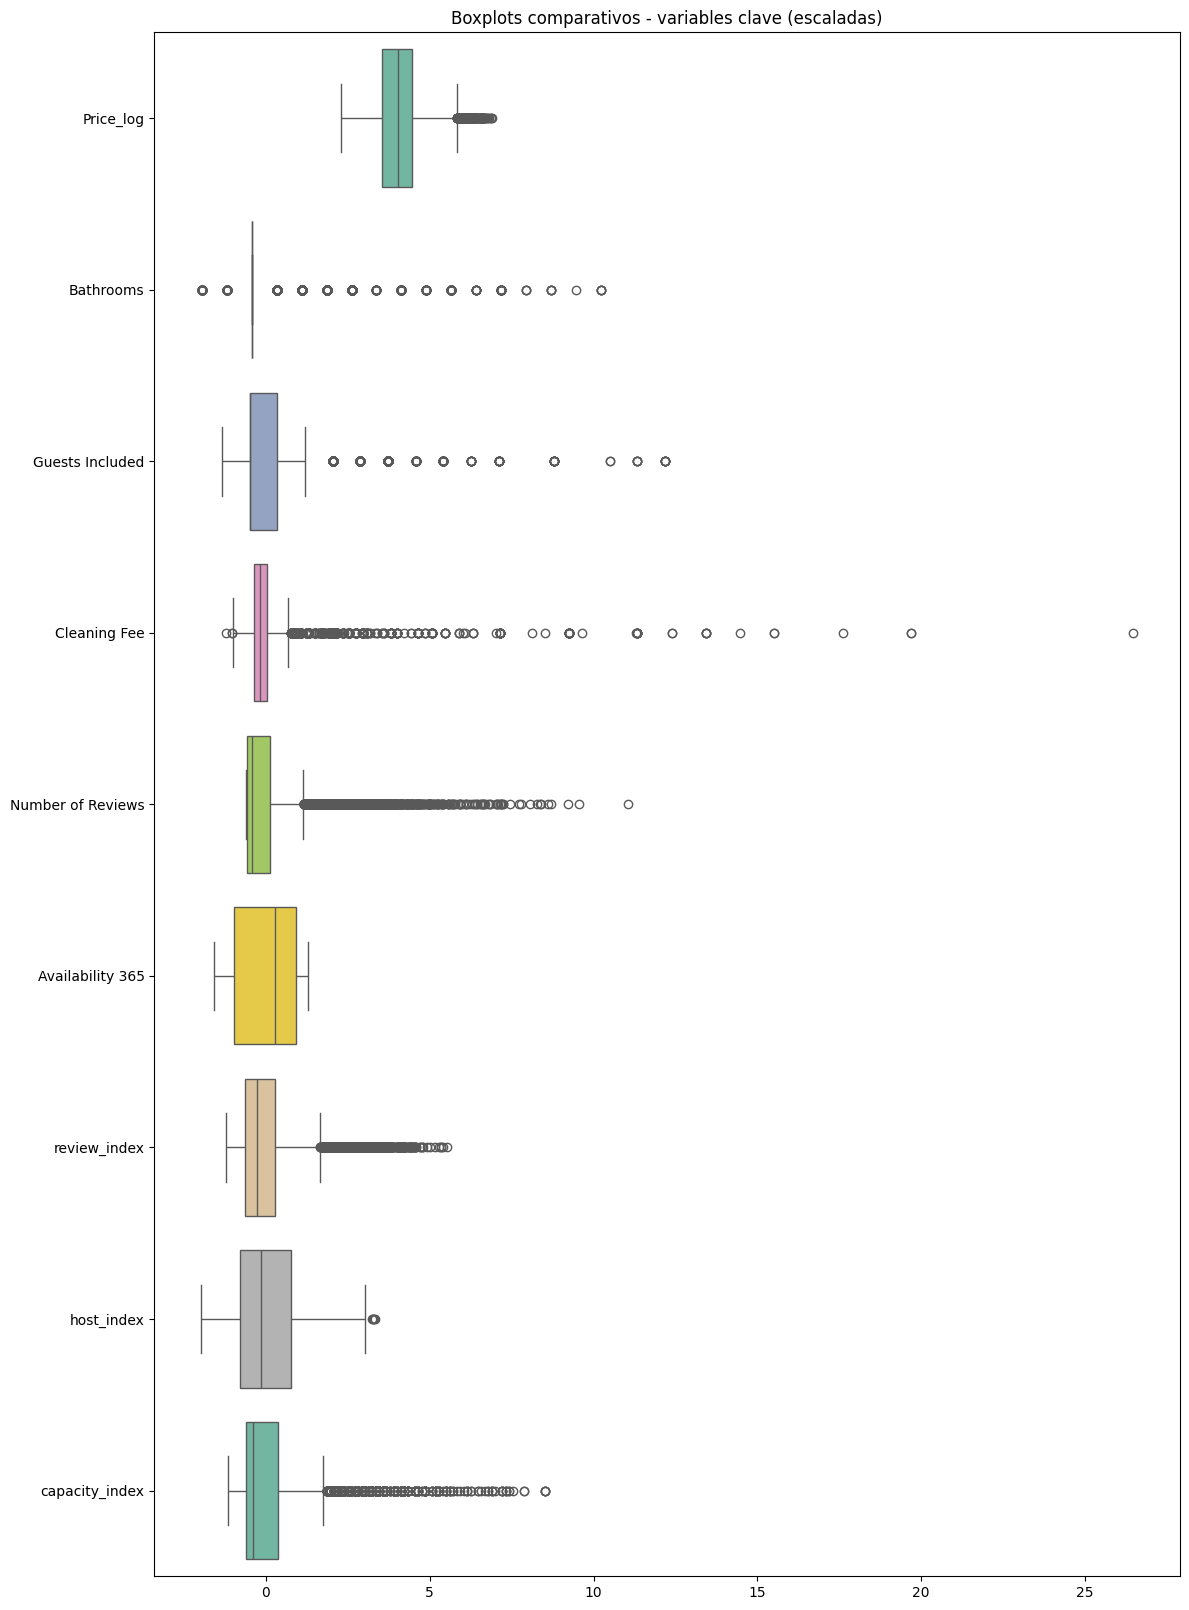

In [83]:
plt.figure(figsize=(12, 1.8 * len(key_vars)))
sns.boxplot(data=df_model_scaled[key_vars], orient='h', palette='Set2')
plt.title("Boxplots comparativos - variables clave (escaladas)")
plt.tight_layout()
plt.show()

Los boxplots comparativos de las variables escaladas muestran varias cosas importantes para validar la preparación del dataset antes del modelado:
- Price_log, que será nuestra variable objetivo, muestra una dispersión controlada y una concentración clara en valores medios. Su forma es consistente con una distribución logarítmica normalizada, lista para modelado.
- Variables como Guests Included, Cleaning Fee, Number of Reviews y capacity_index tienen colas largas con presencia de outliers. Esto no es un problema en sí, ya que fueron estandarizadas, pero sí indica que hay usuarios o propiedades atípicas que podrían influir en modelos sensibles a valores extremos (como regresiones sin regularización).
- Availability 365 se ve mucho más balanceada, con una distribución casi uniforme. Este patrón tiene sentido, ya que algunos anuncios están disponibles todo el año y otros solo ocasionalmente.
- Los índices compuestos como host_index, review_index y capacity_index, aunque aún muestran valores atípicos, tienen una escala controlada gracias al uso de técnicas como PCA y escalado estándar.

In [84]:
df_encoded.to_csv('data/processed/df_model.csv', index=False)
print("Dataset final guardado en 'data/processed/df_model.csv'")

Dataset final guardado en 'data/processed/df_model.csv'
